# Dataset Analysis with Item Response Theory

Item Response Theory (IRT) is a statistical framework from psychometrics which models the relationship between test takers and their responses to test questions.
It models the fact that different test items have different levels of difficulty, and differing abilities to discriminate between skilled and unskilled students.

By treating `syftr` evaluation data as a test, and `syftr` flows as 'students', we can gain deeper insight into our flows and evaluation data.

IRT can help us identify:
* Mislabeled evaluation items
* High and low-impact evaluation items
* Overly difficult or overly easy evaluation datasets
* High-skill flows which might not stand out from the accuracy picture alone

This notebook will walk you through applying a simple 2-Parameter Logistic (2pl) IRT model to your study and interpreting its results.

## Your Study Here
Set the name of the study you would like to examine here.

Studies should have 500 or more completed trials for best results.

In [2]:
STUDY_NAME = "your--study--name--here"

In [1]:
import random
import time

import numpy as np
import pandas as pd
import pyro
import torch
from py_irt.dataset import Dataset as IRTDataset
from py_irt.training import console, IrtModelTrainer, IrtConfig, Path, write_json

from syftr import api

pd.set_option("display.max_rows", 200)


In [3]:
def get_study_dataset_flows(study_name: str):
    study = api.Study.from_db(STUDY_NAME)
    dataset = study.study_config.dataset
    flows_df = study.flows_df
    return study, dataset, flows_df

def get_item_response_matrix(flows_df):
    item_response_matrix = pd.DataFrame(
        list(flows_df.user_attrs_metric_eval_results)
    ).map(lambda x: x['passing'], na_action='ignore')
    
    return item_response_matrix

In [ ]:
study, dataset, flows_df = get_study_dataset_flows(STUDY_NAME)
# Inspect the flows dataframe
console.print(f"syftr flows dataframe for study: {STUDY_NAME}")
flows_df.T

## Item Response Matrix
The Item Response Matrix is the core data structure of IRT.
The columns represent individual test items, while the rows represent test-takers, and values represent the item evaluation - correct or incorrect.

Note that you may have some `NaN` values in your item response matrix.
This is the case for trials which were halted for cost or performance reasons.

In [5]:
item_response_matrix = get_item_response_matrix(flows_df)
console.print(f"# Item Response Matrix for study: {STUDY_NAME}")
item_response_matrix

# Item Response Matrix for study: silver1--in-sample--bright_hf--psychology

,30,31,32,33,34,35,36,37,38,39,...,70,71,72,73,74,75,76,77,78,79
0,0.0,1.0,0.0,1.0,0.0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,1.0,1.0,1.0,0,1,0,1,1,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,1.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1246,1.0,1.0,1.0,1.0,1.0,1,1,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1247,1.0,1.0,1.0,1.0,1.0,0,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1248,1.0,1.0,1.0,1.0,1.0,1,1,0,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


## Measure IRT Parameters

Training an IRT model produces item difficulty and discrimination scores, as well as student (flow) ability scores.

These variables have abstract units, but it's useful to note that the ability and difficulty scores are related.
A student with ability matching the difficulty of a question is estimated to have a 50% chance of correctly answering the question.

This cell will train an IRT model on your data using `py-irt`, `pyro`, and `pytorch`.

Use `device="cpu"` if your computer doesn't have CUDA available.

In [6]:
def train_irt_model(
    item_response_matrix: pd.DataFrame,
    epochs=2000,
    seed=1234,
    device="cuda", # alternative: "cpu"
    output_dir="./dataset_irt_analysis"
):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    dataset = IRTDataset.from_pandas(
        item_response_matrix.reset_index(),
        subject_column="index",
        item_columns=item_response_matrix.columns,
    )
    config = IrtConfig(
        model_type="2pl",
        epochs=epochs,
        log_every=100,
        priors=None,
        initializers=None,
        dims=None,
        lr=0.1,
        lr_decay=0.9999,
        dropout=0.5,
        hidden=500,
        vocab_size=None,
        seed=seed,
        deterministic=True,
        model_config={},
    )
    
    trainer = IrtModelTrainer(
        data_path=Path(output_dir),
        config=config,
        dataset=dataset,
        verbose=True,
    )
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    pyro.set_rng_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)

    start_time = time.time()
    console.log("Training Model...")
    
    trainer.train(device=device)
    trainer.save(output_dir / "parameters.json")
    write_json(output_dir / "best_parameters.json", trainer.best_params)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    console.log("Train time:", elapsed_time)
    
    return trainer


def predict_item_responses(trainer) -> pd.DataFrame:
    """Predict item response (0 or 1) for subjects in the training dataset."""
    dataset = trainer._dataset

    predictions = trainer.irt_model.predict(
        dataset.observation_subjects,
        dataset.observation_items,
    )

    predictions_df = pd.DataFrame({
        "subject_id": dataset.observation_subjects,
        "example_id": dataset.observation_items,
        "response": dataset.observations,
        "prediction": predictions,
    })
    return predictions_df
    

In [22]:
trainer = train_irt_model(item_response_matrix, epochs=2000, device="cpu") # device="cuda")

[14:43:20] Vocab size: None                                                                          ]8;id=886412;file:///home/alex/workspace/syftr/.venv/lib/python3.12/site-packages/py_irt/training.py\training.py]8;;\:]8;id=15328;file:///home/alex/workspace/syftr/.venv/lib/python3.12/site-packages/py_irt/training.py#88\88]8;;\

           Training Model...                                                                        ]8;id=95046;file:///tmp/ipykernel_1490484/436112120.py\436112120.py]8;;\:]8;id=955227;file:///tmp/ipykernel_1490484/436112120.py#48\48]8;;\

           args: {'device': 'cpu', 'num_items': 50, 'num_subjects': 1250}                           ]8;id=36622;file:///home/alex/workspace/syftr/.venv/lib/python3.12/site-packages/py_irt/training.py\training.py]8;;\:]8;id=704185;file:///home/alex/workspace/syftr/.venv/lib/python3.12/site-packages/py_irt/training.py#138\138]8;;\

           Parsed Model Args: {'device': 'cpu', 'num_items': 50, 'num_subjects': 1250, 'priors':    ]8;id=371862;file:///home/alex/workspace/syftr/.venv/lib/python3.12/site-packages/py_irt/training.py\training.py]8;;\:]8;id=248313;file:///home/alex/workspace/syftr/.venv/lib/python3.12/site-packages/py_irt/training.py#151\151]8;;\
           'vague', 'dropout': 0.5, 'hidden': 500, 'vocab_size': None}                                             

Training Pyro IRT Model for 2000 epochs

Output()

[14:43:33] Train time: 13.68469762802124                                                            ]8;id=362900;file:///tmp/ipykernel_1490484/436112120.py\436112120.py]8;;\:]8;id=679808;file:///tmp/ipykernel_1490484/436112120.py#56\56]8;;\

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def print_classifier_metrics(predictions_df, threshold=0.5):
    binary_predictions = (predictions_df['prediction'] >= threshold).astype(int)
    
    accuracy = accuracy_score(predictions_df['response'], binary_predictions)
    precision = precision_score(predictions_df['response'], binary_predictions, zero_division=0)
    recall = recall_score(predictions_df['response'], binary_predictions, zero_division=0)
    f1 = f1_score(predictions_df['response'], binary_predictions, zero_division=0)
    # AUC is already calculated as roc_auc
    
    console.print(f"""--- Classification Metrics (With Prediction Threshold = {threshold}) ---
    Accuracy:               {accuracy:.4f}
    Precision:              {precision:.4f}
    Recall (Sensitivity):   {recall:.4f}
    F1-score:               {f1:.4f}
    """)

    
def plot_prediction_distributions(predictions_df):
    plt.figure()
    sns.kdeplot(predictions_df[predictions_df['response'] == 0]['prediction'], label='Actual: 0 (Incorrect)', fill=True)
    sns.kdeplot(predictions_df[predictions_df['response'] == 1]['prediction'], label='Actual: 1 (Correct)', fill=True)
    plt.title('Distribution of Predicted Probabilities by Actual Class', fontsize=16)
    plt.xlabel('Predicted Probability of Positive Class (1)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()


def plot_roc_curve(predictions_df):
    fpr, tpr, thresholds_roc = roc_curve(predictions_df['response'], predictions_df['prediction'])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()


def plot_confusion_matrix(predictions_df, threshold=0.5):
    binary_predictions = (predictions_df['prediction'] >= threshold).astype(int)
    cm = confusion_matrix(predictions_df['response'], binary_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.title(f'Confusion Matrix (Threshold = {threshold})', fontsize=15)
    plt.show()

## Evaluate Model Fit

Next we must evaluate the quality of the IRT model fit.

To do this, we treat the model as a classifier which predicts whether a given student will answer a question correctly or incorrectly.

We don't need a perfect classifier, but it should "behave" well.
Here are some general criteria we are hoping to see:

* Distinct peaks in the distribution of predicted probabilities. The more distinct the better, but expect some overlap. Use this plot to help choose a reasonable prediction threshold.
* AUC of above 0.85 (see ROC plot)
* More true positives and true negatives than either false negatives or positives.

If these criteria cannot be met by adjusting the prediction threshold, you most likely need to run more trials.

--- Classification Metrics (With Prediction Threshold = 0.55) ---
    Accuracy:               0.8250
    Precision:              0.8573
    Recall (Sensitivity):   0.8976
    F1-score:               0.8770

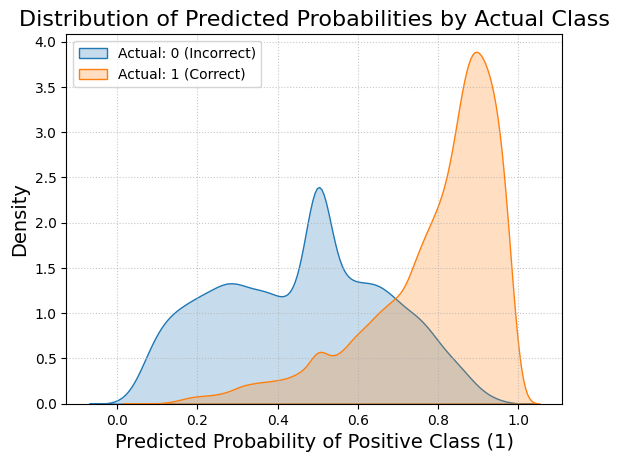

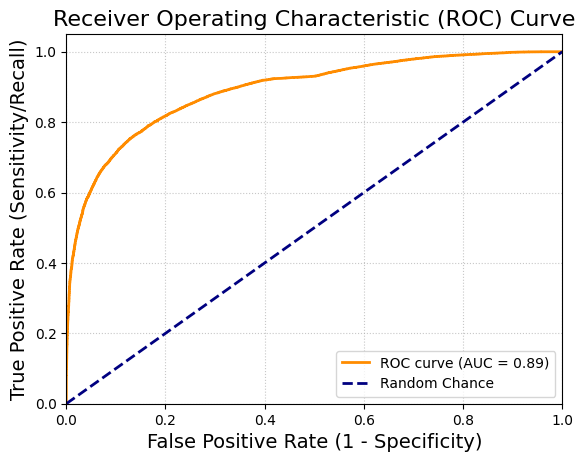

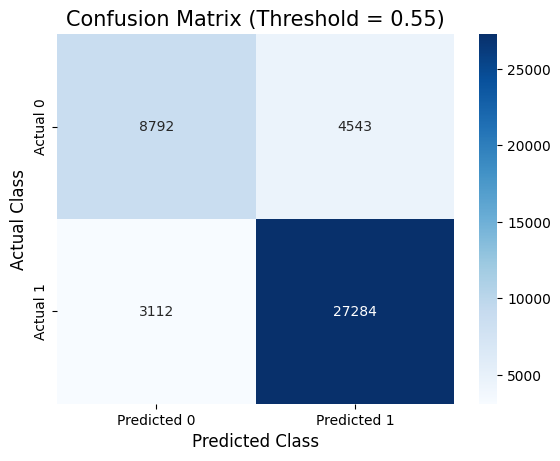

In [9]:
predictions_df = predict_item_responses(trainer)

threshold=0.55
print_classifier_metrics(predictions_df, threshold=threshold)
plot_prediction_distributions(predictions_df)
plot_roc_curve(predictions_df)
plot_confusion_matrix(predictions_df, threshold=threshold)

In [10]:
def get_labeled_qa_pairs(trainer, syftr_dataset) -> pd.DataFrame:
    params = trainer.best_params
    items_df = pd.DataFrame(
        {
            "Question Difficulty": params["diff"],
            "Question Discrimination": params["disc"],
        },
        index=params["item_ids"].values(),
    )
    qa_pairs = list(syftr_dataset.iter_examples())
    qa_pairs_df = pd.DataFrame([qa.model_dump() for qa in qa_pairs]).set_index("id", drop=True)
    qa_pairs_df = pd.concat([qa_pairs_df, items_df], axis=1)
    return qa_pairs_df


def get_labeled_flows(trainer, flows_df) -> pd.DataFrame:
    params = trainer.best_params
    flows_df["Flow Ability"] = params["ability"]
    flows_df["Flow Accuracy"] = flows_df["values_0"]
    flows_df["Flow Cost or Latency"] = flows_df["values_1"]
    return flows_df

## Label the data

Now we apply the IRT model labels (difficulty, discrimination, and ability) to our source data

In [ ]:
qa_pairs_df = get_labeled_qa_pairs(trainer, dataset)
qa_pairs_df

In [ ]:
flows_df = get_labeled_flows(trainer, flows_df)
flows_df.T

# IRT Analysis

Assuming you have verified a decent model fit above, we're now ready to dive into the results!

First we'll talk a little more about the IRT model, and then we'll talk about how to interpret the results.

## 2PL IRT Model

This notebook uses a two-parameter logistic (2pl) model of item difficulty, discrimination, and ability.
In this model, the probability of a student correctly answering the question is given by the following formula:

    P_correct(student, question) = 1 / (1 + exp(-a * (b - θ)))

Where

* **a - Discrimination parameter**: How precisely the question discriminates between subjects of different ability levels.
* **b - Difficulty parameter**: How difficult the question is.
* **θ - Ability parameter**: The skill level of the subject.

The IRT model we trained above identified the most likely values for these parameters across all of the flows and evaluation questions in our study.

## Analyzing IRT Parameters

The first set of charts to look at are histograms of the difficulty, discrimination, and ability parameters for our questions and flows.

### Difficulty and Ability

The Difficulty and Ability plots share an x-axis because they have the same 'unit'.
We hope to see the Question Difficulty plot cover the range of flow Ability scores, and we expect these values to generally be within the range of -3 to +3.

If the difficulty is always high relative to ability, this might indicate that the test is too hard for the evaluated flows. 
You may consider running the study longer to find higher-ability flows, or altering your search space to add higher-capability LLMs and more sophisticated RAG strategies.

If the difficulty is always low, this indicates that the test is relatively easy and you could benefit from finding harder questions for the flows to answer in order to better distinguish between high-performing flows.

If the ability plot shows multiple distinct peaks or is very highly skewed, this indicates that IRT might not be a good fit for your dataset.
IRT theory assumes that ability is normally distributed in the population.
If the results are highly non-normal, then the conclusions you can draw from the process are quite limited.
You may consider narrowing this analysis to only flows with a particular `rag_mode` or other setting, running your study for more trials, or trying a different dataset.

### Discrimination

Discrimination measures how well a question separates between students with ability below and above the question's difficulty level (it controls the slope of the 2pl logistic function).

You should expect to see discrimination values between 0.0 and 2.0 or so, with 1.0 being fairly good discrimination and 0.0 being a practically useless question, where answering the question correctly or incorrectly has no impact on the estimated skill level of the subject.

If you have many questions with low discrimination, you may consider omitting them from your evaluation dataset to improve evaluations.

#### Negative Discrimination

If there are any questions with negative discrimination, this indicates either a poor model fit (especially if you have very low values - below -5), or you may have mislabeled questions which are only answered 'correctly' by low-ability flows.

In [13]:
import matplotlib.gridspec as gridspec

def plot_difficulty_discrimination_ability(qa_pairs_df, flows_df, bins=10):
    fig = plt.figure()#figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
    
    # Plot Question Difficulty on ax1
    ax1.hist(qa_pairs_df['Question Difficulty'], bins=bins)
    ax1.set_title('Question Difficulty')
    ax1.set_ylabel('Frequency')
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), visible=True)

    # Plot Question Discrimination on ax2
    ax2.hist(qa_pairs_df['Question Discrimination'], bins=bins)
    ax2.set_title('Question Discrimination')
    ax2.grid(True)
    plt.setp(ax2.get_yticklabels(), visible=True)

    # Plot Flow Ability on ax3
    ax3.hist(flows_df['Flow Ability'], bins=bins)
    ax3.set_title('Flow Ability')
    ax3.set_xlabel('Ability')
    ax3.set_ylabel('Frequency')
    ax3.grid(True)

    # --- 4. Final Touches ---
    fig.suptitle('2PL Model Parameter Histograms')
    # Use tight_layout to ensure plots and titles don't overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

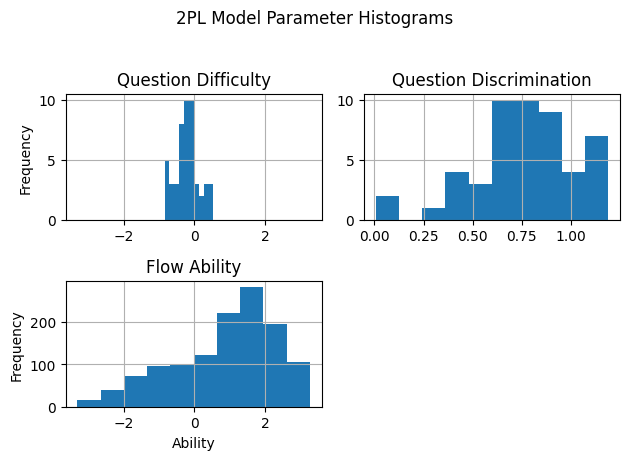

In [14]:
plot_difficulty_discrimination_ability(qa_pairs_df, flows_df)

## Difficulty vs. Discrimination

This scatter plot helps understand the question set a little more.
We hope to see high-discrimination QA pairs across a variety of difficulty levels.

In [15]:
def plot_qa_scatter(df, use_qtype=True):
    hue_param = None # Default to no color grouping
    plot_title = 'Question Difficulty vs. Discrimination'
    
    if 'qtype' in df.columns and len(df.qtype.unique()) > 1:
        df["Question Type"] = df.qtype
        hue_param = 'Question Type'
        plot_title += ' by Question Type'

    sns.scatterplot(
        data=df,
        x="Question Discrimination",
        y="Question Difficulty",
        hue=hue_param,
        palette="viridis" if hue_param else None,
        s=80,
        alpha=0.8
    )
    
    plt.title(plot_title, fontsize=16)
    plt.xlabel("Question Discrimination", fontsize=12)
    plt.ylabel("Question Difficulty", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

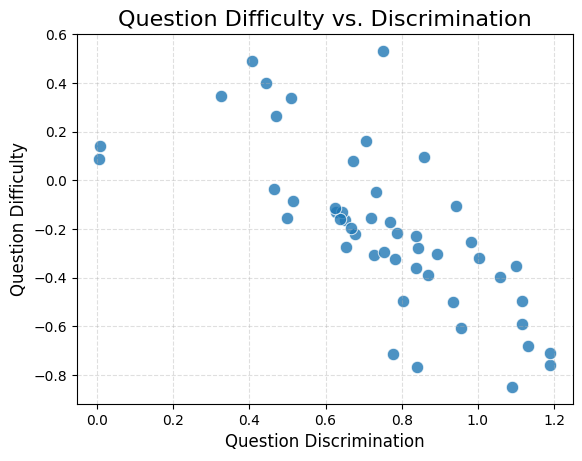

In [16]:
plot_qa_scatter(qa_pairs_df, use_qtype=True)

## Ability vs Accuracy

A core insight of IRT is that not all questions are the same.
Accuracy scores therefore aren't able to fully compare the actual 'skill' levels of different flows.

The "Ability" measure from IRT provides a more nuanced take on skill.

In this plot, we hope to see a roughly linear correlation between flow ability and flow accuracy.
If the band is narrow and straight, this indicates that accuracy is a decent metric for this study.
If the band has more width and nonlinearity, this could indicate a poor dataset, or that ability may be a better measure for flows compared to accuracy.

In [17]:
def plot_flow_ability_accuracy(trainer, flows_df):
    plot_title = 'Flow Ability vs Accuracy'

    
    hue_param = None # Default to no color grouping
    if 'params_rag_mode' in flows_df.columns and len(flows_df.params_rag_mode.unique()) >= 2:
        flows_df["RAG Mode"] = flows_df.params_rag_mode
        hue_param = 'RAG Mode'
        plot_title += ' by RAG Mode'

    params = trainer.best_params
    
    flows_df["Flow Ability"] = params["ability"]
    flows_df["Flow Accuracy"] = flows_df["values_0"]
    
    sns.scatterplot(
        data=flows_df,
        x="Flow Accuracy",
        y="Flow Ability",
        hue=hue_param,
        palette="viridis" if hue_param else None,
        s=80,
        alpha=0.6
    )
    
    plt.title(plot_title, fontsize=16)
    plt.xlabel("Flow Accuracy", fontsize=12)
    plt.ylabel("Flow Ability", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

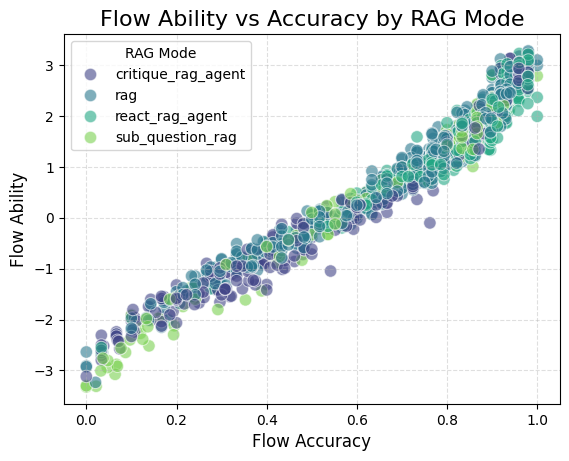

In [18]:
plot_flow_ability_accuracy(trainer, flows_df)

## Ability and Accuracy vs Cost or Latency

This final pair of plots compares the standard `syftr` Pareto plot of accuracy versus cost or latency (depending on which you have set as your study's second optimization objective), against the plot of _ability_ versus cost or latency.

What we should expect to see here is that plotting ability gives a more balanced distribution of scores in the y axis, giving more nuance to the picture of flow skill levels.

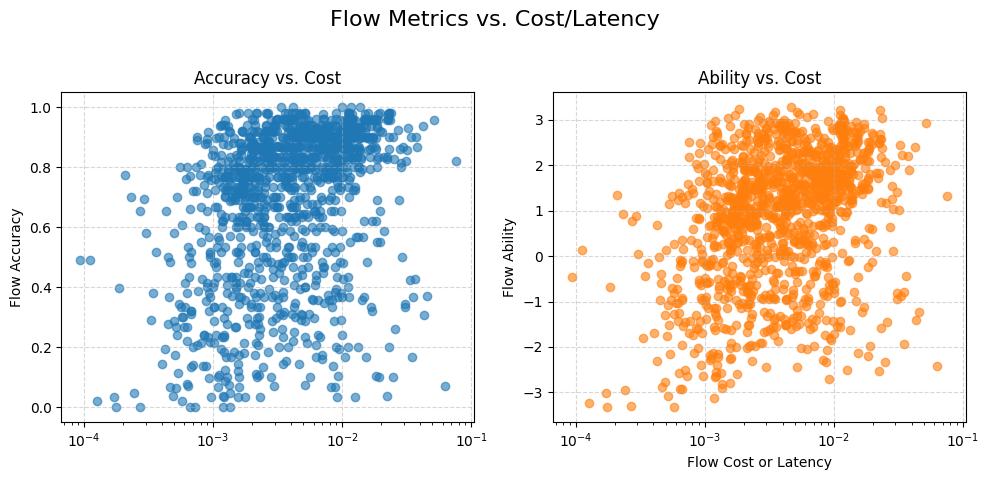

In [26]:
def plot_accuracy_ability_vs_cost(flows_df):
    """
    Creates two vertically stacked scatter plots sharing an x-axis.

    - Top Plot: Flow Accuracy vs. Flow Cost or Latency
    - Bottom Plot: Flow Ability vs. Flow Cost or Latency

    Args:
        flows_df (pd.DataFrame): A DataFrame that must contain the columns
                                 'Flow Cost or Latency', 'Flow Accuracy', and 'Flow Ability'.
    """
    # --- 1. Create the figure and subplots ---
    # plt.subplots(2, 1) creates a figure with 2 rows and 1 column of subplots.
    # sharex=True ensures that both plots will share the same x-axis,
    # and zooming/panning will be linked.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True)

    fig.suptitle('Flow Metrics vs. Cost/Latency', fontsize=16)

    # --- 2. Create the Top Plot (Accuracy vs. Cost) ---
    ax1.scatter(flows_df['Flow Cost or Latency'], flows_df['Flow Accuracy'], alpha=0.6)
    ax1.set_ylabel('Flow Accuracy')
    ax1.set_title('Accuracy vs. Cost')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # We don't set the x-label here because it's shared with the bottom plot.

    # --- 3. Create the Bottom Plot (Ability vs. Cost) ---
    ax2.scatter(flows_df['Flow Cost or Latency'], flows_df['Flow Ability'], alpha=0.6, color='C1')
    ax2.set_ylabel('Flow Ability')
    ax2.set_xlabel('Flow Cost or Latency') # The shared x-axis label
    ax2.set_title('Ability vs. Cost')
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_xscale('log')

    # --- 4. Display the Plot ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

plot_accuracy_ability_vs_cost(flows_df)

## Direct Review of QA Pairs

Finally, we can analyze each individual QA pair to understand what makes questions easy or hard, discriminating or nondiscriminating.

Questions are sorted from least to most discriminating - we are most interested in the least discriminative questions, because these are the most likely mislabeled or low-value.

In [27]:
from rich.console import Console
from rich.rule import Rule
from rich.text import Text

def display_questions_with_stats(questions_df: pd.DataFrame, responses_df: pd.DataFrame, item_response_matrix: pd.DataFrame):
    """
    Displays question data with performance stats derived from a responses DataFrame.
    Uses distinct, high-contrast colors for all stats.
    """
    # --- 1. Preparation ---
    df_sorted = questions_df.sort_values(by="Question Discrimination", ascending=True)

    metrics = {
        "Question Difficulty": (df_sorted["Question Difficulty"].min(), df_sorted["Question Difficulty"].max()),
        "Question Discrimination": (df_sorted["Question Discrimination"].min(), df_sorted["Question Discrimination"].max()),
        #"q_guessability": (df_sorted["q_guessability"].min(), df_sorted["q_guessability"].max()),
    }

    def get_color_style(value: float, metric: str, high_is_good: bool = False) -> str:
        """Calculates a color from green (good) to red (bad)."""
        min_val, max_val = metrics[metric]
        if max_val == min_val: return "rgb(173,216,230)"
        normalized = (value - min_val) / (max_val - min_val)
        if high_is_good: normalized = 1 - normalized
        red = int(255 * normalized)
        green = int(255 * (1 - normalized))
        return f"rgb({red},{green},0)"

    # --- 2. Display Loop ---
    console = Console()
    total_subjects = len(responses_df)

    for index, row in df_sorted.iterrows():
        # --- Divider using the DataFrame index as the ID ---
        console.print(Rule(f"[bold white]ID: {index}", style="dim white"))

        # --- Question & Answer ---
        console.print(f"[bold cyan]❓ Question:[/bold cyan] {row['question']}")
        console.print(f"[bold yellow]💡 Labeled Answer:[/bold yellow] [italic]{str(row['answer'])}[/italic]")

        # --- Calculate new stats from responses_df ---
        if index in item_response_matrix.columns:
            question_col = item_response_matrix[index]
            correct_pct = question_col.mean() * 100
            answered_count = question_col.notna().sum()
            response_rate_pct = (answered_count / total_subjects) * 100 if total_subjects > 0 else 0

            # MODIFICATION: Using "bright_magenta" for Response Rate
            stats_text = Text.assemble(
                ("✅ Correct Responses: ", "bold"), (f"{correct_pct:.1f}%", "bright_green"), ("  |  ", "dim"),
                ("👥 Response Rate: ", "bold"), (f"{response_rate_pct:.1f}%", "bright_magenta"), (f" ({answered_count}/{total_subjects})", "dim")
            )
        else:
            stats_text = Text.assemble(("No response data found for this question.", "red"))

        # --- IRT Model Scores ---
        diff_style = get_color_style(row["Question Difficulty"], "Question Difficulty")
        disc_style = get_color_style(row["Question Discrimination"], "Question Discrimination", high_is_good=True)
        #gues_style = get_color_style(row["q_guessability"], "q_guessability")

        irt_scores_text = Text.assemble(
            ("📊 ", "bold"), ("Difficulty: ", "bold"), (f"{row['Question Difficulty']:.2f}", diff_style), (" | ", "dim"),
            ("Discrimination: ", "bold"), (f"{row['Question Discrimination']:.2f}", disc_style), (" | ", "dim"),
            #("Guessability: ", "bold"), (f"{row['q_guessability']:.2f}", gues_style)
        )

        console.print(irt_scores_text)
        console.print(stats_text)


In [28]:
display_questions_with_stats(qa_pairs_df, flows_df, item_response_matrix)

───────────────────────────────────────────────────── ID: 70 ──────────────────────────────────────────────────────

❓ Question: What is the term for the rhetorical, "How hard could it be?"

I looked through the wikipedia page listing cognitive biases looking for a bias that describes the tendency to 
assume a poorly understood problem must be simple. Planning fallacy is kind of in the right ballpark; it gets the 
underestimation part, but I am associating the behaviour with a snap decision more than a plan. Is there another 
that fits better?

I really thought it would be easy to find this term on wikipedia. I mean, how many psychological terms could there 
possibly be?

💡 Labeled Answer: $\begingroup$

I believe the closest match is the [ illusion of control
](https://en.wikipedia.org/wiki/Illusion_of_control) :

> ... the tendency for people to overestimate their ability to control events;
> for example, it occurs when someone feels a sense of control over outcomes
> that they demonstrably do not influence. ... people base their judgments of
> control on "skill cues". ... When more of these skill cues are present, the
> illusion is stronger.

This bias only operates when a plausible case can be made for one's skill or
intent influencing outcomes - such as a programming task given to a
programmer. In such instances, how well the task or problem is understood, its
actual level of difficulty, and the actual level of control over outcomes are
overestimated or ignored.

[ Positive illusions ](https://en.wikipedia.org/wiki/Positive_illusions) \-
biases that describe how people overestimate their own abilities, success, and
control - are the broader category that contains the illusion of control, and
the [ planning fallacy ](https://en.wikipedia.org/wiki/Planning_fallacy) ,
among others. These biases typically go away when estimating the success of
others instead of one's self.

There is another bias worth noting here, called the [ hard-easy effect
](https://en.wikipedia.org/wiki/Hard%E2%80%93easy_effect) :

> ... a tendency to overestimate the probability of one's success at a task
> perceived as hard, and to underestimate the likelihood of one's success at a
> task perceived as easy. ... "Hard tasks tend to produce overconfidence but
> worse-than-average perceptions," ...

This bias also ignores how well understood a problem is, but it suggests that
a problem perceived as hard (whether or not it actually is) is more likely to
result in overestimating success. This bias is not as robust or widely
accepted as the former.

📊 Difficulty: 0.09 | Discrimination: 0.01 | 

✅ Correct Responses: 32.8%  |  👥 Response Rate: 23.4% (293/1250)

───────────────────────────────────────────────────── ID: 44 ──────────────────────────────────────────────────────

❓ Question: Bias distrusting area of expertise while implicitly trusting other domains?

I've run across descriptions of this bias before, but cannot find it right now... I checked Wikipedia's list of 
cognitive biases to no avail.

Basically, people working in some domain and having expertise in it, naturally tend to notice the problems in that 
area, such as incompetence of other people working in their field, bad policies and poor management decision 
making, etc, resulting in a disproportionate distrust of their own field of expertise. For example, healthcare 
workers are more likely to be vaccine hesitant because they distrust their own industry more than most due to 
personal experience with incompetence, mismanagement, politics, and corruption within their field.

However, this distrust does not carry over to other domains. So for example, watching a movie that portrays 
something you have domain knowledge in, you will quickly notice the inaccuracies and misrepresentation, but 
portrayals of domains outside your expertise will naturally be believable and perceived as accurate. Similarly, 
reading news stories about topics that you have expertise in, you will notice inaccuracies and bias immediately, 
but fail to recognize that the same level of inaccuracy and bias must exist in domains outside your area of 
expertise, implicitly treating such news stories as accurately reported.

What is this bias called?

💡 Labeled Answer: $\begingroup$

I found what I was looking for. It's called the [ Gell-Mann Amnesia
](https://www.epsilontheory.com/gell-mann-amnesia/) effect:

> ... You open the newspaper to an article on some subject you know well. ...
> you read with exasperation or amusement the multiple errors in a story, and
> then turn the page to national or international affairs, and read as if the
> rest of the newspaper was somehow more accurate about Palestine than the
> baloney you just read. You turn the page, and forget what you know.

That quote is attributed to Michael Crichton, who named the effect after his
physicist friend Murray Gell-Mann, who discovered it.

This effect is not studied in psychology as far as I can tell, so it may not
be real, but having a name for it helps learn at least that much.

📊 Difficulty: 0.14 | Discrimination: 0.01 | 

✅ Correct Responses: 12.7%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 32 ──────────────────────────────────────────────────────

❓ Question: Can you use harmful addictions to build good habits?

I am reading the Pavlov's dog experiments, from it I learn that associating a dopamine high event with a neutral 
event will lead to later that neutral event triggering the same receptors in absence of the dopamine high event. I 
thought about this and wondered... what if I started doing some harmful addictions like cigarettes and smokes 
before studying something I may not be interested in... does this mean I would later associate studying with the 
kicks of these two harmful habits?

P.S: I am not saying to do these illicit substances in excess, just a mild amount where your brain can still 
function.

The above was the motivation, now is the real question: Has there been human trials based on this principle using 
illicit substances to train the mind in a positive way? Was it succesful..?

💡 Labeled Answer: $\begingroup$

Although smoking is highly addictive and should never be started just because
you feel like it enables you to learn something you are not particularly
interested in [ Heishman et al. (2010)
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3151730/) note that:

> The significant effects of nicotine on motor abilities, attention, and
> memory likely represent true performance enhancement because they are not
> confounded by withdrawal relief. The beneficial cognitive effects of
> nicotine have implications for initiation of smoking and maintenance of
> tobacco dependence.

Note that tobacco smoking is not only addictive because of nicotine, but also
because tobacco smoke contains potent MAO inhibitors which are speculated to
potentiate the effects of nicotine. [ Berlin & Anthenelli (2001)
](https://watermark.silverchair.com/4-1-33.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAsUwggLBBg
kqhkiG9w0BBwagggKyMIICrgIBADCCAqcGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMezGRNW4qQDPOzxBOAgEQgIICeDHUGcLTucxMdWmPu9fIS
9agdfpzeIljHgK-
gShT0EwX0_vEjW6FIQGasR9XL6MFS5k32D_0THoXqyImMTSZi5OlHkJbYB0hZJJsDYxhQF9l2hZ56aOI5HePRggp-K7y0w_SVKV7DYCS0Ij_hHfqOpj
LWgym4IBIfCIu30gnJf64Xg9qMpHUbPRKK1c9C_0vGGj4zhv6xrIQaSayF7xGantNvnfvQQzy_f5ATGF-
TKmCnEhad0WyMT1pn33o3YrqbCrWFtIS7ypdhty9dncmt635ctlK1349uYRzdehE4xz386-5ytwFFxNS8hFR3Qv2mFr427UL3n_lSjAhIWp3KWdTSmI
elMcOHckmQeRm7SLspwZWRuMwnPkU2ju4xQOaV4dkCQqVYseNmPGeOBrQUhe-6xemXZRxIvB2J4RoE-
rZelVNGCIzcUhxtGjIglFJTuzbAmrtFH7CWXA5ofxgN2xlMsw7kvzbgWpwrOYT6Z-qSTe7WsSXeevnNzmz1EyYsZ_LqG8nzR_YB7i20syUrpALDz54t
Ckt29pme_WZWZGrm1iuyXdKlgazLzqUHHZyt4eAw2SMugcVz10XYaoAUjLt6ZeAiZEBODDDK-S30ikXFWK1dGj55dubhalOMrs7URga10f9pnAKlHam
jSicyyIJzvOqHediGogl7h_INtg76NkNKE3zrpMKobo5tDf9z340mMJ-
KvZiADxYN-
PfNf_Ub3M2IKCohJJ7kD2Ixjv0PLPjvVqLd4i6SL3yKpF2b__RSxfj5hPaVwdfYhbzjvX34L867d9Zfs3u6SP5BH_8buT-
gpGK78Xtel4nzHBM2ioPlek_Xvxo) note that:

> We examine the hypothesis that chronic habitual smoking can be better
> understood in the context of two pharmacological factors : nicotine and
> reduced MAO activity. We speculate that MAO inhibition by compounds found in
> either tobacco or tobacco smoke can potentiate nicotine’s effects

Thus if you want to try nicotine your last choice should be smoking. There is
[ snus ](https://en.wikipedia.org/wiki/Snus) or buy nicotine gum. Also
consider talking to a professional so (s)he can recommend medication like [
methylphenidad ](https://en.wikipedia.org/wiki/Methylphenidate) or similar
medication.

Let me give you another suggestion to start micro-dosing caffeine (-powder). [
Sholey et al. (2008)
](https://www.sciencedirect.com/science/article/pii/S0195666308000196) note
that:

> Cognitive performance, mood, autonomic activity and salivary caffeine were
> assessed pre-dose and at 1, 3, 6 and 9 h post-dose. Compared with placebo,
> performance was impaired by 2.5 mg, whilst 5 mg had negative effects on mood
> and mixed effects on performance and 10 mg improved performance.

Another paper about microdosing caffeine reports:

> This study measured the effects of 0, 12.5, 25, 50 and 100 mg caffeine on
> cognitive performance, mood and thirst in adults with low and moderate to
> high habitual caffeine intakes.Effects on performance and mood confirmed a
> psychostimulant action of caffeine. All doses of caffeine significantly
> affected cognitive performance, and the dose-response relationships for
> these effects were rather flat. [ Rogers & Smit (2000): Effects of low doses
> of caffeine on cognitive performance, mood and thirst in low and higher
> caffeine consumers
> 
](https://idp.springer.com/authorize/casa?redirect_uri=https://link.springer.com/article/10.1007/s002130000506&casa
_token=4uoqOueuEW8AAAAA:9P5TrKWNJJvC9fPZq5SDR5F8s2AuhBlFJ2xAlGX2pugXAqRnPkMX1-30ziDKWo1gvN_IYhf55IGRdY3hGPs)

The effects of caffeine can be enhanced by L-theanin as found in tea (camellia
sinensis). A meta-analysis of the combined effects of caffeine and L-theanin
notes that:

>

📊 Difficulty: 0.35 | Discrimination: 0.32 | 

✅ Correct Responses: 44.5%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 56 ──────────────────────────────────────────────────────

❓ Question: Identify kind of descriptive role playing game for self-discovery

There's a comic book called "Knights of the Dinner Table" about a bunch of rpg players.

In one issue, the only girl at the table GM's some kind of self-discovery game she learnt in her psychology class. 
She describes some situations and asks for details from the players, giving an example herself.

At one point, for example, she says:

Ok, so you continue your journey down your own personal path. Soon you come to a large bear! What do you do? My 
bear turns out to be very tame and I'm able to hand feed it and befriend it! He decides to accompany me on my 
journey.

At the end, she explains what each thing symbolizes:

The bear represents adversity and how you deal with it

Supposedly this is (loosely) based on a real exercise for self discovery. I would like to know more about the real 
exercise in which this is based, but I don't know how to start.

Any idea how this exercise is called, or how can I find more information about something similar?

Thanks.

💡 Labeled Answer: $\begingroup$

I finally found it, apparently it's called [ The Forest Test
](https://exploringyourmind.com/the-forest-test-and-its-place-in-
psychoanalysis/)

> Hindrances and annoyances that take away our happiness, entrenched fears,
> values ​​that govern our choices and behavior. The forest test tries to
> clarify and interpret many of these issues based on the approach from which
> it was designed: relational psychoanalysis. According to this theory, our
> psychological suffering is rooted in underlying issues that we must bring to
> light in order to heal the hurts and move forward.
>
> For those who have not heard about this relational test, we should first say
> that it isn’t in any way conventional. The forest test doesn’t have enough
> reliability and validity to be part of normal clinical practice. However, we
> cannot rule out its relevance within the context and the theoretical
> framework from which it was created. It is, without a doubt, worth taking
> into account.
>
> The forest test is a projective test which can reveal the fears, hindrances
> and deepest interests of each patient.

📊 Difficulty: 0.49 | Discrimination: 0.41 | 

✅ Correct Responses: 45.9%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 49 ──────────────────────────────────────────────────────

❓ Question: Name of the psychological effect that make us see correlation that may not exist

After 51 years, the "Z-340" cypher text from "Zodiac" serial killer has been solved: 
https://edition.cnn.com/2020/12/11/us/zodiac-killer-cypher-340-code-trnd/index.html

Now that we have the problem and the solution, when I'm watching the cypher text again I'm like "Ho.. look, look, 
it's so obvious! The sign must mean this and that and the following letter is transposed according to the sign and 
if you like at this and that there is a clear relationship between the age of the captain and whatever this thing 
mean!! Ha! It must be!"

Even knowing that it's just wishful thinking, I'm still willing it to be true: "Yeaaah, it's probably, 99.99% sure,
just me imagining things.. BUT! That 0.01% doubt, I want it to be true anyway."

There is a name for this effect. I don't think it's the Barnum effect, it may or may not be a "confirmation bias". 
What is this effect called?

💡 Labeled Answer: $\begingroup$

The feeling that the solution is obvious after it is provided is called [
hindsight bias ](https://en.wikipedia.org/wiki/Hindsight_bias) (aka the "knew-
it-all-along phenomenon").

This feeling is informed by the metacognitive sense of surprise, which itself
is a form of [ processing fluency
](https://en.wikipedia.org/wiki/Processing_fluency) . Basically, when the
solution to a problem is first given, it is surprising (lacks fluency), and
hence judged as difficult. However, when the solution is known or provided
again, it is no longer surprising (has fluency), and hence judged as easy.
People often underestimate the difficulty (or predictability) of solutions (or
events) after knowing the outcome, due to this bias.

In the example provided in the question however, it is not clear that you
actually know the solution, only that you feel that you know the solution
after it was solved by someone else. In this case, you really do have a case
of [ wishful thinking ](https://en.wikipedia.org/wiki/Wishful_thinking) .

📊 Difficulty: 0.40 | Discrimination: 0.44 | 

✅ Correct Responses: 47.7%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 66 ──────────────────────────────────────────────────────

❓ Question: Attractiveness bias, based on political views

I've noticed that if I agree with the political/cultural/religious views of a person, then he looks sort-of 
beautiful (physical appearance), even if he (or she) happens to be ugly.

I've also noticed that if people disagree strongly with a person's political views, they think he or she is ugly 
(as an example, think of the many caustic comments on the looks of Hillary Clinton and Donald Trump).

My question is: What is the name of this phenomenon?

I know that "Attractiveness bias" is a term describing the opposite phenomenon: if a person looks beautiful, we 
think he's wise.

But I'm asking here about the opposite direction: if a person is wise (according to our subjective opinion, of 
course), then we think he looks beautiful. I tried googling this but couldn't come up with any discussion of this.

💡 Labeled Answer: $\begingroup$

It is a negative/reverse [ halo effect
](https://en.wikipedia.org/wiki/Halo_effect) , aka a [ horns (or devil) effect
](https://en.wikipedia.org/wiki/Horn_effect) .

📊 Difficulty: -0.04 | Discrimination: 0.47 | 

✅ Correct Responses: 70.7%  |  👥 Response Rate: 26.7% (334/1250)

───────────────────────────────────────────────────── ID: 31 ──────────────────────────────────────────────────────

❓ Question: Has there ever been a split brain pianist?
Asked 2 years, 6 months ago
Modified 2 years, 5 months ago
Viewed 634 times
0

Has there ever been a split brain pianist?

I was thinking about this yesterday and it occurred to me that a split brain pianist might have an advantage over a
non-split brain pianist; they could potentially read the bass and treble clef lines independently and thus process 
the lines independently. Perhaps this advantage would be meaningless at the professional level, but it surely could
have the potential to make it easier for beginner pianists. I spent some time searching but was unfortunately 
unable to find any case studies of this.

I did, however, find a case study of a ex-professional pianist with alien hand syndrome whose symptoms were 
exacerbated when playing the piano, but it wasn't what I was looking for.

I'd also be interested in any examples of split brain patients who were able to play any instrument at all – I'd 
find the outcomes fascinating.

💡 Labeled Answer: $\begingroup$

Your hypothesis that those suffering from split-brain syndrome

> could potentially read the bass and treble clef lines independently and thus
> process the lines independently. Perhaps this advantage would be meaningless
> at the professional level, but it surely could have the potential to make it
> easier for beginner pianists.

is flawed. That is because communication between the two brain hemispheres is
required in order to learn to play the piano.

Encyclopaedia Britannica [ points out that
](https://www.britannica.com/science/split-brain-syndrome)

> **Split-brain syndrome** , also called **callosal disconnection syndrome** ,
>  condition characterized by a cluster of neurological abnormalities
> arising from the partial or complete severing or lesioning of the [ corpus
> callosum ](https://www.britannica.com/science/corpus-callosum) , the bundle
> of nerves that connects the right and left hemispheres of the [ brain
> ](https://www.britannica.com/science/brain) .
>
> **[...]** *
>
> The primary cause of split-brain syndrome is intentional severing of the
> corpus callosum, partially or completely, through a surgical procedure known
> as corpus callosotomy. Rarely performed in the 21st century (having been
> replaced largely by drug treatments and other procedures), this operation is
> reserved as a last measure of treatment for extreme and uncontrollable forms
> of [ epilepsy ](https://www.britannica.com/science/epilepsy) in which
> violent seizures spread from one side of the brain to the other.

With regard to playing a piano with the corpus callosum completely severed,
Encyclopaedia Britannica [ also points out that
](https://www.britannica.com/science/split-brain-syndrome) (emphasis mine)

> Many patients with split-brain syndrome retain intact memory and social
> skills. Split-brain patients also maintain motor skills that were learned
> before the onset of their condition and require both sides of the body;
> examples include walking, swimming, and biking. They can also learn new
> tasks that involve either parallel or mirrored movements of their fingers or
> hands. **They cannot, however, learn to perform new tasks that require
> interdependent movement of each hand, such as learning to play the piano,
> where both hands must work together to produce the desired music** .

So therefore, beginner pianists will not be able gain any more abilities with
playing the piano, and pianists will not be able to learn any new pieces of
music as it will involve learning how to coordinate each hand with the notes
within the piece.

The anterior half of the corpus callosum is significantly larger in musicians
( [ Schlaug, et al. 1995 ](https://doi.org/10.1016/0028-3932\(95\)00045-5) ),
@AliceD points out in the excellent [ answer to **Unilateral vision in split
brain subjects** ](https://psychology.stackexchange.com/a/21155/7604)

>   * The corpus callosum is not necessary for low-level visual processing;
>   * Both eyes project to both hemispheres; the left visual hemifield of both
> eyes is projected to the left hemisphere, the right hemifield to the right.
>

and [ Chappell (1999) ](https://doi.org/10.1017/S0265051799000340) also points
out that;

> It is argued that in terms of brain usage, technical skills and note-reading
> are based largely in the left-hemisphere, while the less used skills of
> improvisation, memorisation and internalisation are based in the right-
> hemisphere.

##  References

Chappell, S. (1999). Developing the complete pianist: A study of the
importance of a whole-brain approach to piano teaching. _British Journal of
Music Education, 16_ (3), 253-262. [ https://doi.org/10.1017/S0265051799000340
](https://doi.org/10.1017/S0265051799000340)

Sand, R. (n.d.). Split-brain syndrome: Pathology _Encyclopaedia Britannica_ [
https://www.britannica.com/science/split-brain-syndrome
](https://www.britannica.com/science/split-brain-syndrome)

Schlaug, G., Jäncke, L., Huang, Y., 

📊 Difficulty: 0.26 | Discrimination: 0.47 | 

✅ Correct Responses: 50.8%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 62 ──────────────────────────────────────────────────────

❓ Question: I am looking for the name of a phenomenon where people blindly follow others when they sense a threat

So I am composing a post and I am looking for a name of the behaviour among people that they start running when 
they see two or more people running in opposite direction sensing a potential threat or when two or more people are
looking upwards, others also start looking upwards. Such phenomena is recorded in various funny videos compilations
and I would like to know if there is any name of such phenomena or any description of such phenomena that I can 
refer to in the post?

💡 Labeled Answer: $\begingroup$

[ Herd mentality ](https://en.wikipedia.org/wiki/Herd_mentality) (aka mob
mentality) involves people following others without (deliberate) thinking -
ie, impulsively or blindly:

> ... describes how people can be influenced by their peers to adopt certain
> behaviors on a largely emotional, rather than rational, basis.

Most experiments in herd mentality involve strangers. There are other terms
for non-impulsive behaviors (Wikipedia lists group intelligence, crowd wisdom,
groupthink, deindividuation, and decentralized decision making).

That is contrasted with [ swarm behavior
](https://en.wikipedia.org/wiki/Swarm_behaviour) . Herd mentality usually
refers to individuals conforming to or blindly following others, whereas swarm
behavior does not involve individuals doing the same thing:

> ... it is an emergent behaviour arising from simple rules that are followed
> by individuals and does not involve any central coordination.

Rather, in swarm behavior, individuals make different decisions depending on
what others around them are doing, such as avoiding predators based on the
reactions of others. Confusingly, "herding" is swarm behavior (in insects it's
called swarming; but fish school, birds flock, and mammals herd).

📊 Difficulty: -0.15 | Discrimination: 0.50 | 

✅ Correct Responses: 78.2%  |  👥 Response Rate: 30.4% (380/1250)

───────────────────────────────────────────────────── ID: 48 ──────────────────────────────────────────────────────

❓ Question: What is the scientific term for the erroneous inversion of cause and effect?

What is the correct scientific term for the - erroneous - inversion of cause and effect?

💡 Labeled Answer: $\begingroup$

According to a [ dictionary of psychology
](https://books.google.com/books?id=0uxnglHzYaoC&pg=PA844) this is simply
called "reverse causality"

> In attempting to understand the relationship between cause and effect, a
> tendency to attribute what is actually the cause to the effect. For example,
> does the ingestion of lead paint cause a lower intelligence quotient (IQ) or
> is it that children with lower IQs tend to eat lead paint?

📊 Difficulty: 0.34 | Discrimination: 0.51 | 

✅ Correct Responses: 51.8%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 77 ──────────────────────────────────────────────────────

❓ Question: What is it called to attack a person then say something uplifting?

Say a manager emailing the people under her in a way that to them feels degrading, and putting down. But at the end
of the email its encouraging/uplifting type saying I know you are intelligent and capable people.

So is there a name of this type of behavior to attack/degrade then at the end say something nice?

💡 Labeled Answer: $\begingroup$

It sounds like a variant on the [ **sandwich technique**
](https://www.findlay.edu/blog/feedback-sandwich-approach) , which is
advocated by some as the preferred way to deliver critical feedback to a
person, like a student or employee. The sandwich technique can be defined as:

> ...offer a piece of negative feedback “sandwiched" between two positive
> ones, thus easing the blow of the critique.

Note that this technique is criticized, because people might not remember the
crucial middle critical part of the message, because of the **[ recency effect
](https://psychology.iresearchnet.com/social-psychology/decision-
making/recency-effect/) ** : our brains are hardwired to remember the first
and last bits of a conversation whilst glossing over the middle part (source:
[ WeQ ](https://www.weq.io/post/why-the-sandwich-feedback-doesnt-work-and-
what-to-do-instead) ).

📊 Difficulty: -0.09 | Discrimination: 0.51 | 

✅ Correct Responses: 76.0%  |  👥 Response Rate: 19.4% (242/1250)

───────────────────────────────────────────────────── ID: 75 ──────────────────────────────────────────────────────

❓ Question: Getting upset from the creation of your own imagination 

Lets say I got angry at someone who did/said something wrong. Even after this angry interaction with this person is
finished, I noticed I continue to express my negative reaction in my head creating some imaginary situation where 
this specific person is doing/saying something wrong (which they didn't do/say in real life; it's totally in my 
head, a creation of my negative imagination). It wastes my time, mental energy, breaks my focus/concentration at 
productive work, and definitely it's long term effect on my mental health cannot be good.

I just wanted to know -
- What this problem/issue is known as (just so I can do a little more research online)?

💡 Labeled Answer: $\begingroup$

Yes, this is a common experience. I often see people walking around gesturing
and talking quietly but intensely to themselves; amusing that we not only have
these imaginary conversations, but can hardly resist moving our faces and
bodies in concert with those thoughts. Broadly speaking, humans often engage
in counterfactual reasoning: imagining things that aren't. This has been
proposed as one of the most unique features of human cognition relative to
other animals.

A key related concept is rumination [
https://en.wikipedia.org/wiki/Rumination_(psychology)
](https://en.wikipedia.org/wiki/Rumination_\(psychology\)) , which are
negative and often repeated thoughts without new insight.

This is also related to mindfulness—awareness of what is currently
happening—which is a tool to recognize when one gets lost in thought. It is
not trivial just to realize that it is thought, rather than something that is
actually happening.

Also see the psychology term [ https://psychcentral.com/lib/what-is-
catastrophizing/ ](https://psychcentral.com/lib/what-is-catastrophizing/) :
"Catastrophizing is an irrational thought a lot of us have in believing that
something is far worse than it actually is. Catastrophizing can generally can
take two different forms: making a catastrophe out of a current situation, and
imagining making a catastrophe out of a future situation."

📊 Difficulty: -0.11 | Discrimination: 0.63 | 

✅ Correct Responses: 90.1%  |  👥 Response Rate: 19.4% (242/1250)

───────────────────────────────────────────────────── ID: 63 ──────────────────────────────────────────────────────

❓ Question: How can humans tell when something diverges from the norm

With this I mean the notion of humans being able to, for example, look at a painting and tell that something 
doesn't belong in there. For example sun glasses on the Mona Lisa, without prior knowledge of the painting. I just 
find it easier to spot or add things to something that are wrong than to add something that fits in perfectly.

I found some pointers to Gestalt Theory but I couldn't find anything there yet. I'll keep looking but maybe someone
here knows what I'm trying to convey. Thanks.

💡 Labeled Answer: $\begingroup$

The [ predictive coding ](https://en.wikipedia.org/wiki/Predictive_coding)
model of brain function suggests that the entire function of the brain is to
update an internal model of the world.

This process occurs by generating predictions based on the current model, and
comparing these predictions to sensory information. The difference between the
predictions and the actual information is the _prediction error_ : this is the
stuff that the brain has to work harder on, because it is these errors that
require further action to update the models and make better predictions in the
future.

Based on this model, **unexpected things are highly salient** , because they
generate large prediction errors. In contrast, _expected_ things are boring,
and can mostly be ignored. This is a mechanism to filter the massive amount of
sensory information we are capable of taking in at any given moment.

As of now, predictive coding is still just a model, and there is a lot of work
being done towards finding evidence for predictive coding in the brain. That
said, it explains the phenomenon you are describing fairly well.

* * *

Some references for further reading:

Bastos, A. M., Usrey, W. M., Adams, R. A., Mangun, G. R., Fries, P., &
Friston, K. J. (2012). Canonical microcircuits for predictive coding. Neuron,
76(4), 695-711.

Kok, P., & de Lange, F. P. (2015). Predictive coding in sensory cortex. In An
introduction to model-based cognitive neuroscience (pp. 221-244). Springer,
New York, NY.

Melloni, L., van Leeuwen, S., Alink, A., & Müller, N. G. (2012). Interaction
between bottom-up saliency and top-down control: how saliency maps are created
in the human brain. Cerebral cortex, 22(12), 2943-2952.

Rao, R. P., & Ballard, D. H. (1999). Predictive coding in the visual cortex: a
functional interpretation of some extra-classical receptive-field effects.
Nature neuroscience, 2(1), 79-87.

Spratling, M. W. (2012). Predictive coding as a model of the V1 saliency map
hypothesis. Neural Networks, 26, 7-28.

Yuille, A., & Kersten, D. (2006). Vision as Bayesian inference: analysis by
synthesis?. Trends in cognitive sciences, 10(7), 301-308.

📊 Difficulty: -0.13 | Discrimination: 0.63 | 

✅ Correct Responses: 80.0%  |  👥 Response Rate: 30.4% (380/1250)

───────────────────────────────────────────────────── ID: 71 ──────────────────────────────────────────────────────

❓ Question: How to improve working memory in adults?

Think Better on Your Feet: How to Improve Your Working Memory in: A Man's Life, Money & Career

Brett and Kate McKay • September 20, 2016, Last updated: October 17, 2018 
https://www.artofmanliness.com/articles/think-better-feet-improve-working-memory/

Training Working Memory: Why and how Make your working memory work for you. William R. Klemm Ph.D. 
https://www.psychologytoday.com/us/blog/memory-medic/201203/training-working-memory-why-and-how

Klemm makes the claim IQ is not fixed. He claims IQ improves dramatically in the early school years in all 
children. Moreover, a recent study shows that both verbal and non-verbal IQ can change (for better or worse) in 
teenagers. The recent study is cited in the above psychology today web link.

Is it a fact or a neuromyth to claim IQ is not fixed for adults? Processing speeds slow down as we get older, and 
working memory steadily deteriorates/declines as we get older, too. Are we doomed to get slower and have poorer 
working memories as we get much older (50, 60s, 70s, 80s)?

Or can we maintain our intelligence, working memory, and processing speeds for a longer period of time if we do 
physical exercise, keep physically fit, and live healthy lives?

💡 Labeled Answer: $\begingroup$

IQ is not the same as working memory (either visual or non-visual). IQ is
deprecated in favor of the term general intelligence (g).

Education improves g, but not by much; only about one point per year of
education ( [ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4445388/
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4445388/) ), where about 15
points are a standard deviation.

Many things affect general intelligence negatively, such as lead exposure or
inadequate nutrition. However, once basic good conditions are experienced,
cognitive decline is not avoidable. The good news is that while g decreases in
older adults, semantic memory (knowledge) can continue increasing, such that
real-world performance on many tasks need not suffer.

Beware a huge range of companies and hucksters promoting activities to slow
cognitive decline: to my knowledge, none of them have much validation nor a
consensus of scientists without conflicts of interest (e.g., financial).

📊 Difficulty: -0.16 | Discrimination: 0.64 | 

✅ Correct Responses: 84.6%  |  👥 Response Rate: 23.4% (293/1250)

───────────────────────────────────────────────────── ID: 69 ──────────────────────────────────────────────────────

❓ Question: Impaired verbal communication, but normal reading and writing skills?

Is there any cognitive disability or disfunction that impairs both speech production and listening comprehension, 
while reading and writing skills are at a normal level or better?

💡 Labeled Answer: $\begingroup$

Just a reminder that Stack Exchange is not an appropriate place to get a
diagnosis; a vague description of symptoms may indicate a variety of possible
outcomes. See a doctor instead. That said:

One general term for disorders that affect some language modalities and not
others, when the cause is psychological rather than physical (ie, not
deafness, muscle weakness, paralysis, etc), is [ aphasia
](https://en.wikipedia.org/wiki/Aphasia) :

> To be diagnosed with aphasia, a person's speech or language must be
> significantly impaired in one (or several) of the four communication
> modalities following acquired brain injury or have significant decline over
> a short time period (progressive aphasia). The four communication modalities
> are auditory comprehension, verbal expression, reading and writing, and
> functional communication.

Aphasia is most commonly associated with stroke or dementia, and several [
sub-types ](https://en.wikipedia.org/wiki/Aphasia#Classification) involve both
speech production and verbal comprehension difficulties, while not necessarily
affecting reading or writing abilities.

Other diagnoses are also possible, as [ language disorders
](https://en.wikipedia.org/wiki/Language_disorder) may consist of a
combination of a variety of possible aspects of language ability, while not
affecting others. For example, children with both receptive (comprehension)
and expressive (speech) delays may be diagnosed with [ specific language
impairment (SLI) ](https://en.wikipedia.org/wiki/Specific_language_impairment)
:

> ... diagnosed when a child's language does not develop normally and the
> difficulties cannot be accounted for by generally slow development, physical
> abnormality of the speech apparatus, autism spectrum disorder, apraxia,
> acquired brain damage or hearing loss.

Though relatively rarely, it is possible for literacy to be largely unaffected
by SLI.

Additionally, [ comorbidity ](https://en.wikipedia.org/wiki/Comorbidity) is
also possible, such as a combination of speech [ agnosia
](https://en.wikipedia.org/wiki/Auditory_verbal_agnosia) and [ apraxia
](https://en.wikipedia.org/wiki/Apraxia_of_speech) , and if other symptoms are
present, then yet other diagnoses would apply, such as [ autism
](https://en.wikipedia.org/wiki/Autism_spectrum) , where again, it is possible
for some language skills (such as verbal communication) to be impaired while
others (such as literacy) are largely unaffected.

For a general overview of the field, see [ speech and language impairment
](https://en.wikipedia.org/wiki/Speech_and_language_impairment) and [
communication disorder ](https://en.wikipedia.org/wiki/Communication_disorder)
. A summary of technical terminology used to classify symptoms can be found [
here ](https://en.wikipedia.org/wiki/List_of_language_disorders) .

📊 Difficulty: -0.13 | Discrimination: 0.64 | 

✅ Correct Responses: 83.8%  |  👥 Response Rate: 26.7% (334/1250)

───────────────────────────────────────────────────── ID: 65 ──────────────────────────────────────────────────────

❓ Question: Thinking about What Others Think of You

When a mind develops, it goes through numerous stages of awareness, such as (not necessarily in order)

Awareness of others
Awareness of self
Awareness of other's thoughts (this may not be a discrete stage)
What do you call the awareness of other's awareness of you (and the logical deduction of what they believe you're 
thinking)?

I believe this should be the stage before meta-gaming is possible.

💡 Labeled Answer: $\begingroup$

This sort of thinking is called [ theory of mind
](https://en.wikipedia.org/wiki/Theory_of_mind) (not to be confused with
theories of how the mind works).

It's not entirely clear whether theory of mind is a discrete ability or a
spectrum, but tasks requiring higher-order theorizing tend to be more
difficult and are more likely to be lost to dysfunction:

> Cognitive theory of mind is further separated into first order (e.g., I
> think she thinks that…) and second order (e.g., he thinks that she thinks
> that…)

I'm not aware of a specific term that distinguishes second-order theory of
mind when the second-order person is in fact the first-person rather than a
third-person (e.g., "she thinks that I think that...").

📊 Difficulty: -0.16 | Discrimination: 0.65 | 

✅ Correct Responses: 86.5%  |  👥 Response Rate: 26.7% (334/1250)

───────────────────────────────────────────────────── ID: 76 ──────────────────────────────────────────────────────

❓ Question: How do we know what colors animals perceive?

Humans have three kinds of photoreceptors corresponding to different wavelength-spectra:

If say photons with wavelengths of around 530 nanometers hit the human retina, this would lead to the perception of
the color conventionally called "green". The color "green", however, is subjective in the sense that it is bound to
a certain cortical physiology.

So my question is: Given that we don't have access to how animals perceive color, as we can't infer such 
qualitative properties purely from physical stimulus properties, how can we conclude that some animals are, say, 
perceiving ultra-violet colors given certain items or wavelengths? What if they would perceive entirely different 
colors than known to us?

💡 Labeled Answer: $\begingroup$

There are some levels of confusion in this in question, but basically we can
test

  * what wavelengths animals perceive (simple behavioral tests, e.g. training & testing them to distinguish a 
certain wavelength) 
  * inspect their cones to determine what wavelengths they could perceive. The latter doesn't necessarily imply 
that if an animal has say 4 different cones, it has tetrachromatic vision, because there's some degeneracy in some 
species, which unlike in humans (which have 3 types of cones and trichromatic vision) don't really use all their 
cones. 

To give you a nearly random example of such a paper (this species doesn't have
degeneracy), a (freely available) [ paper on chicks' vision
](http://jeb.biologists.org/content/jexbio/202/21/2951.full.pdf) :

> The colour vision of domestic chicks (Gallus gallus) was investigated by
> training them to small food containers decorated with tilings of grey and
> coloured rectangles. Chicks learn to recognise the colour quickly and
> accurately. Chicks have four types of single-cone photoreceptor sensitive to
> ultraviolet, short-, medium- or long-wavelength light. To establish how
> these receptors are used for colour vision, stimuli were designed to be
> distinguished only by specific combinations of receptors. We infer (1) that
> all four single cones are used, and (2) that their outputs are encoded by at
> least three opponency mechanisms: one comparing the outputs of ultraviolet-
> and short-wavelength-sensitive receptors, one comparing the outputs of
> medium- and long-wavelength receptors and a third comparing of the outputs
> of short- and long- and/or medium-wavelength receptors. Thus, the chicks
> have tetrachromatic colour vision. These experiments do not exclude a role
> for the fifth cone type, double cones, but other evidence suggests that
> these cones serve luminance-based tasks, such as motion detection, and not
> colour recognition.

If you want to get philosophical qualia discussions, akin to [ whether all
humans describe the same color with same language
](https://en.wikipedia.org/wiki/Linguistic_relativity_and_the_color_naming_debate)
, that's a whole different kettle of fish. I don't know of any studies like
that in the absence of language. I'm guessing you might be familiar with [ the
dress ](https://en.wikipedia.org/wiki/The_dress) .

📊 Difficulty: -0.27 | Discrimination: 0.65 | 

✅ Correct Responses: 90.9%  |  👥 Response Rate: 19.4% (242/1250)

───────────────────────────────────────────────────── ID: 79 ──────────────────────────────────────────────────────

❓ Question: Term/phrase for remembering the negative over the positive

I work in UX (user experience) which involves a lot of psychological principles to various degrees and came across 
an interesting thought about bad experiences.

My question is, is there some kind of common term or phrase for a person that remembers past negative situations 
more clearly than positive ones?

I was thinking of the example of news reports about plane crashes. The percentage of negative incidents across the 
world is minute but since people only hear about the negative, this is how they perceive the majority. Therefore 
their memory of the bad news stories will outweigh their memory of their last successful flight. This can cause 
people to see air travel as dangerous.

There are probably better examples of this but I hope that makes sense.

💡 Labeled Answer: $\begingroup$

There isn't a name (that I am aware of at least) for a _person_ who has this
experience, but the concept is referred to as [ negativity bias
](https://en.wikipedia.org/wiki/Negativity_bias) .

Negativity bias is a general phenomenon, though certainly individuals can vary
as to how strongly they are influenced by negative rather than positive
events/information.

📊 Difficulty: -0.19 | Discrimination: 0.67 | 

✅ Correct Responses: 90.5%  |  👥 Response Rate: 19.4% (242/1250)

───────────────────────────────────────────────────── ID: 37 ──────────────────────────────────────────────────────

❓ Question: What is the neurobiological mechanism behind masochism?

I tried to search in textbooks and papers but barely found any concrete answer to which exact mechanism is behind 
non-intuitive transition from pain to pleasure. Does it have something to do with:

just the effect of dopamine (once the pain is administered, endorphins inhibit GABA and increase dopamine release)?
initially decreased levels of beta-endorphins in the brain, so that pain increases DA release as in (1) and even 
this small release is enough to feel the pleasure? And, as in people who are prone to self-harm, is it some kind of
a "desperate attempt to artificially set the body to survival mode in order to mobilize the last reserves of the 
endogenous opioid system"?
lower sensitivity (to pain?) in such people?
some other explanations?
If someone have the answer or ran into papers addressing this question, I would be grateful!

💡 Labeled Answer: $\begingroup$

The first paper I found was this one:

[ Kamping, S., Andoh, J., Bomba, I. C., Diers, M., Diesch, E., & Flor, H.
(2016). Contextual modulation of pain in masochists: involvement of the
parietal operculum and insula. Pain, 157(2), 445.
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4795098/)

They note:

> Masochists reported substantially reduced pain intensity and unpleasantness
> in the masochistic context compared with controls but had unaltered pain
> perception in the other conditions

The context-dependence of this effect suggests to me to favor a "top-down"
modulation explanation, rather than a "bottom-up" neurochemical one involving
endorphins and dopamine.

The authors continue:

> The masochists compared with the controls displayed attenuated functional
> connectivity of the parietal operculum with the left and right insulae, the
> central operculum, and the supramarginal gyrus. Masochists additionally
> showed negative correlations between the duration of interest in masochistic
> activities and activation of areas involved in motor activity and affective
> processing. We propose that the parietal operculum serves as an important
> relay station that attenuates the affective-motivational aspects of pain in
> masochists.

So indeed, their results suggest that the higher-order perception of pain is
different in masochists during masochistic activities. It's difficult to make
causal conclusions from these data, however in general this isn't something
that's going to be easy to study causally. I'm not aware of any model of
masochism in model organisms, so approaches are going to be fairly limited to
observational studies of humans.

📊 Difficulty: 0.08 | Discrimination: 0.67 | 

✅ Correct Responses: 60.8%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 78 ──────────────────────────────────────────────────────

❓ Question: Is there a proper name of learning by experience (i.e. feeling something subconsciously)?

We all know about these two ways of learning:

Rote learning (by mechanically repeating something to remember it).
Learning by understanding (by understanding the logic behind something).
But I strongly believe, that one more way of learning exists - learning by feeling. But do we have a term or some 
explanation for this type of learning?

Some examples:

you can learn the formula for least-count of device by:
repeating it to remember it whenever required;
understanding it to derive it whenever required;
by feeling it, i.e. using the device for some time, to enable us to put that formula in our subconscious mind;
(better example) in chemistry, we can learn the effect of 𝑁𝑂2
 on benzene, the following ways:
repeating it;
understanding its chemical nature, its structure and then concluding the results;
by seeing examples of its reactions and feeling that that is its behavior, to happen like this.

💡 Labeled Answer: $\begingroup$

Maybe what you are looking for is [ tacit knowledge
](https://en.wikipedia.org/wiki/Tacit_knowledge) :

> Tacit knowledge is the kind of knowledge that is difficult to transfer to
> another person by means of writing it down or verbalizing it. For example,
> that London is in the United Kingdom is a piece of explicit knowledge that
> can be written down, transmitted, and understood by a recipient. However,
> the ability to speak a language, ride a bicycle, knead dough, play a musical
> instrument, or design and use complex equipment requires all sorts of
> knowledge that is not always known explicitly, even by expert practitioners,
> and which is difficult or impossible to explicitly transfer to other people.

> With tacit knowledge, people are not often aware of the knowledge they
> possess or how it can be valuable to others. Effective transfer of tacit
> knowledge generally requires extensive personal contact, regular interaction
> and trust. This kind of knowledge can only be revealed through practice in a
> particular context and transmitted through social networks. To some extent
> it is "captured" when the knowledge holder joins a network or a community of
> practice.

Another word that may suit your description is [ intuition
](https://en.wikipedia.org/wiki/Intuition#Modern_psychology) :

> Intuition is the ability to acquire knowledge without proof, evidence, or
> conscious reasoning, or without understanding how the knowledge was
> acquired. Different writers give the word "intuition" a great variety of
> different meanings, ranging from direct access to unconscious knowledge,
> unconscious cognition, inner sensing, inner insight to unconscious pattern-
> recognition and the ability to understand something instinctively, without
> the need for conscious reasoning.

> Instinct is often misinterpreted as intuition and its reliability considered
> to be dependent on past knowledge and occurrences in a specific area. For
> example, someone who has had more experiences with children will tend to
> have a better instinct about what they should do in certain situations with
> them. This is not to say that one with a great amount of experience is
> always going to have an accurate intuition.

📊 Difficulty: -0.22 | Discrimination: 0.68 | 

✅ Correct Responses: 89.7%  |  👥 Response Rate: 19.4% (242/1250)

───────────────────────────────────────────────────── ID: 50 ──────────────────────────────────────────────────────

❓ Question: Is fasting an effective method to overcome substance addictions?

I recently watched a testimony of a man who reports the results of a 40-day water/juice fast (no food). The 
individual claims to have been addicted to drugs for 22 years, including marijuana, cocaine, mushrooms, LSD, 
ecstasy, prescription pain pills and alcohol. He went cold turkey, abstaining from both food and addictive 
substances during the 40-day fast. After the fast, he reports complete freedom and no relapses.

This particular case raised my interest in the potential benefits of fasting in the addiction recovery arena. After
a quick search I found this site which claims that:

Fasting is by far the most sophisticated willpower workout available. If you get good at fasting, you can learn to 
control every other aspect of your life. If you get good at fasting, you can overcome any addiction, not matter how
deeply imbedded. Medically, fasting has been found to rapidly dissipate the craving for nicotine, alcohol, caffeine
and other drugs.

Is it true that any addiction can be overcome with the skills learnt by fasting? Are there studies on the 
effectiveness of fasting for overcoming substance addictions or any other addiction for that matter?

💡 Labeled Answer: $\begingroup$

> Is it true that any addiction can be overcome with the skills learnt by
> fasting?

Perhaps for some people, but different people have different levels of craving
for food and other pleasurable substances. [ And drugs may further influence
this ](https://academic.oup.com/nutritionreviews/article/79/6/627/5911317)

> Substances like heroin may compete with food in the brain activating reward
> pathways and increasing dopamine receptor’ availability, thus suppressing
> the appetite and leading to lower body weight.

As a personal anecdote, I can easily water fast for many days, but I find
going a full day without cannabis or other addictive substances to be
extremely challenging, so this is definitely not true for all people. [ Drug
addicts tend to be skinnier
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2837874/) than the general
populations, [ consume less food and have lower appetite
](https://academic.oup.com/nutritionreviews/article/79/6/627/5911317) .

> In the short term, opiates cause anorexia, decreased food consumption, and
> reduced gastrointestinal motility, all leading to malnutrition and increased
> risk of infections in the long term.

And stimulant users such as meth addicts can easily go days without eating due
from simply being too focused on other things to even think about food.

📊 Difficulty: 0.16 | Discrimination: 0.71 | 

✅ Correct Responses: 59.7%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 73 ──────────────────────────────────────────────────────

❓ Question: Is there a specific term for the notion of storing "algorithms" in human memory?

It seems to me that there is a pretty sharp distinction between storing a "fact" like "Chickens are birds" and 
storing an algorithm or routine like "how to multiply two 3-digit numbers". I find the latter idea to be very 
interesting, and I'd like to read more on what has been written on this subject, but I don't know how people in 
psychology/ cognitive science denote this specific aspect (if they even make such a distinction at all).

I'm familiar with the ideas of episodic and semantic memory, and it seems that memorizing an algorithm like the one
mentioned above, falls into the overall domain of "semantic memory", but within that area, I'm not finding the 
term(s) that deal with representation/ storage of this kind of algorithmic/ routine based knowledge (as opposed to 
"simple facts").

"Sequence memory", as used by Hawkins in this paper seems to come close to capturing some of the spirit of what I 
mean, but that doesn't seem to be exactly right either.

💡 Labeled Answer: $\begingroup$

This is called [ procedural memory
](https://en.wikipedia.org/wiki/Procedural_memory) .

In textbooks, memory is often broken down into a hierarchy of types. Note that
this taxonomy is primarily a guide to language use - ie, how types of memory
are labelled or referred to, not how memory is actually organised in the
brain. In standard hierarchies, recalling a mathematical formula would fall
under [ semantic memory ](https://en.wikipedia.org/wiki/Semantic_memory) ,
while the process of applying the formula would be stored in procedural
memory.

[ ![Memory breakdown](https://i.sstatic.net/fiEKk.jpg)
](https://i.sstatic.net/fiEKk.jpg)

Procedural memory is considered [ implicit (unconscious) memory
](https://en.wikipedia.org/wiki/Implicit_memory) , and is most often
associated with motor skill or [ muscle memory
](https://en.wikipedia.org/wiki/Muscle_memory) , but includes any learned
procedure or process. Notably, the [ process of learning
](https://en.wikipedia.org/wiki/Procedural_memory#Acquisition_of_skill) a
motor skill (such as riding a bike) mirrors that of learning a cognitive skill
(such as playing chess), in that initially, the process can be acquired
consciously (explicit), but with practice, it becomes unconscious (implicit).

📊 Difficulty: -0.16 | Discrimination: 0.72 | 

✅ Correct Responses: 89.1%  |  👥 Response Rate: 23.4% (293/1250)

───────────────────────────────────────────────────── ID: 34 ──────────────────────────────────────────────────────

❓ Question: Why are there so few women in math and science Olympiads?

Why are there so few women in math olympics (IMO and etc)? If this is also related to the low participation of 
women in the Olympics compared to men, I would like to know.

Why Are There Still Only Few Women in Science An interesting article you can find on Nytimes about why low number 
of women in science

I also found some studies that try to explain why women's participation in math olympics is low. They have shown 
that many women also believe the stereotype that women are bad at math. Women who hold this belief may be reluctant
to compete in math competitions, so it probably makes up for this effect.

Women and Mathematics: Stereotypes, Identity, and Achievement Both Genders Think Women Are Bad at Basic Math

I sent some studies that I read and found relevant.

💡 Labeled Answer: $\begingroup$

This is my first answer here, so bear with me. Suggestions on how to make this
answer better are welcome.

There are several studies that indicate that men are more interested in things
and women are more interested in people.

  * [ https://pubmed.ncbi.nlm.nih.gov/19883140/ ](https://pubmed.ncbi.nlm.nih.gov/19883140/)
  * [ https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00189/full 
](https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00189/full)

In Scandinavia where genders are the most equal there is a bigger gap between
men and women in the STEM fields. Which suggests that the interest in people
or things is biological and not perse social or cultural.

  * [ 
https://www.telenor.com/wp-content/uploads/2019/09/The-Gender-Gap-in-Technology-in-Scandinavia_Full-report.pdf 
](https://www.telenor.com/wp-content/uploads/2019/09/The-Gender-Gap-in-Technology-in-Scandinavia_Full-report.pdf)

To compete in the math olympics you need to be really good in what you do. Or
for the sake of argument to be a high level engineer or any other high level
position in the STEM field.

You will have more men than women. Because there are less women to begin with.

Plus women excel in verbal skills. So they have more options outside STEM
fields only.

  * [ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4270278/ 
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4270278/)

📊 Difficulty: -0.31 | Discrimination: 0.73 | 

✅ Correct Responses: 72.0%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 53 ──────────────────────────────────────────────────────

❓ Question: Term for the tendency to relate events that occurred in proximity?

What is the correct scientific term for the tendency to wrongfully relate arbitrary observations to a significant 
event, just because they occurred in temporal or spatial proximity?

Most recently I have observed this error in a discussion about an unsolved killing, where a participant was quite 
sure that her observation of a black van in a far away town was related to the killing, for the single reason that 
it occurred around the same time.

💡 Labeled Answer: $\begingroup$

This is informally referred to as the [ illusion of causality
](https://doi.org/10.3389/fpsyg.2015.00888) :

> Illusions of causality occur when people develop the belief that there is a
> causal connection between two events that are actually unrelated. Such
> illusions have been proposed to underlie pseudoscience and superstitious
> thinking, sometimes leading to disastrous consequences in relation to
> critical life areas, such as health, finances, and wellbeing.

This is a cognitive error in the way humans [ infer cause and effect
](https://en.wikipedia.org/wiki/Causal_reasoning#Inferring_cause_and_effect) .

The example that I'm most familiar with is in medical quackery. Suppose
someone is experiencing constipation. They try some advice from friends: Go
for a long walk, eat some prunes, massage their stomach, use magnesium
supplements. Then they try more questionable solutions: Probiotics, colon
hydrotherapy, acupuncture, herbal medicines. At some point during the process,
the constipation is relieved, and the patient naturally concludes that
whatever treatment immediately preceded this event must have been the cure.
They "swear by this treatment" from then on, failing to consider that prior
treatments may have needed more time to take effect, that other activities not
considered treatments may have affected the results (eg, regular exercise,
dietary changes), or simply the mere passage of time.

📊 Difficulty: -0.05 | Discrimination: 0.73 | 

✅ Correct Responses: 64.1%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 35 ──────────────────────────────────────────────────────

❓ Question: How long does an area clean-up help it stay clean?

Sometime in middle or high school I remember coming across this popular thinking of, when an area or neighbourhood 
has some trash, it makes people think it's ok to litter there themselves, and the more trash there is, the more of 
an unspoken 'norm' littering becomes. However, the hope was that the reverse is also true, and if a neighbourhood's
cleaned up, then it signals to people that littering is the anti-norm here.

But I have gone on trash cleaning walks around my neighbourhood in the past few months, and I can't say that that 
hope is totally founded. The street by my apartment building has trash reemerge with a vengeance within a week. It 
makes me think there's some discrepancy in how this is thought about. Like, it's harder to see during night-time, 
so it absolves you from confronting the results of trash on the grass, and the like.

Are there long-term studies around (various) neighbourhoods that study this behaviour, and detangle and clarify the
different factors at play here? Other studies are good too.

💡 Labeled Answer: $\begingroup$

Research indeed demonstrates that littering is significantly more frequent
when there is existing litter - for reviews, see [ Huffman et al (1995)
](https://doi.org/10.1177%2F0013916595272003) , and [ Geller et al (1982. pp
84-97) ](https://books.google.ca/books?id=RuBSAAAAMAAJ) .

A more recent review by [ Vos et al (2018)
](https://doi.org/10.1108/JFM-06-2017-0025) summarizes:

> Among researchers, there is a general consensus that littering is
> significantly more likely to occur in a littered setting than in a litter-
> free setting.

The authors discuss a number of other factors known to reduce littering
behaviour, including the presence of others, existing litter being in piles,
seeing other people picking up trash, and the scent of cleanser. Factors that
increase littering include lack of trash cans, and the [ broken windows effect
](https://en.wikipedia.org/wiki/Broken_windows_theory) .

As for long-term observational studies, your best bet is probably [ Schultz et
al (2013) ](https://doi.org/10.1177%2F0013916511412179) :

> Findings are reported from coded observations of the littering behavior
> among 9,757 individuals at 130 outdoor public locations

Some interesting findings from this study:

> ... of all 8,990 individuals that were observed moving through a diverse
> range of sites, 4% littered.
>
> ... the large majority (85%) of littering behavior results from individual-
> level variables (e.g., age, gender, attitudes, and motivation) ... 15% of
> the variance in observed littering behavior was due to some aspect of the
> context (e.g., existing litter, lack of convenient receptacles, etc.).
>
> ... for every unit increase in the amount of existing litter (from 0-10),
> the observed littering rate increased by 2%.

Lots more detail in the paper.

📊 Difficulty: 0.53 | Discrimination: 0.75 | 

✅ Correct Responses: 52.2%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 74 ──────────────────────────────────────────────────────

❓ Question: Difference between Psychology & Neuroscience in lay man terms?

I am electronics engineer by profession But i am confused in difference between Psychology & Neuroscience? Please 
explain in lay man terms?

💡 Labeled Answer: $\begingroup$

This will be a little contrived (you asked in layman's terms), but basically
psychologists don't care about neurons. They care more about a higher-level
view of how the brain works.

There's even a joke about psychologists having a [ "neuron envy"
](https://www.apa.org/monitor/2008/06/neuroscience) . As for an example:

> The problem is that you can have an explanation in biology at two different
> levels. One is a "black box," or non-reductionist approach. An example of
> this is behaviorism, which gives you a model of what's going on at the same
> level as the phenomenon you are studying.

And as an analogy

> In biology, for example, Mendelian genetics--where you have pea plants and
> genes--could only get you so far. Sooner or later, you need to open it up
> and see what's inside. You have to discover the structure of the DNA
> molecule--an advance that gave birth to modern biology, because it told you
> about enzymes; it told you about ... the machinery underlying cell
> physiology.
>
> In psychology, the nearest thing to that happening is neuroscience.

📊 Difficulty: -0.30 | Discrimination: 0.75 | 

✅ Correct Responses: 92.8%  |  👥 Response Rate: 23.4% (293/1250)

───────────────────────────────────────────────────── ID: 72 ──────────────────────────────────────────────────────

❓ Question: task-fMRI to determine TMS site (online stimulation with that same task)?

I am planning an experiment whereby rTMS would be administered to subjects while they perform a language task, with
the hopes of improving performance on this task as compared to sham stimulation.

Due to the novel nature of this task, it is difficult to predict the most optimal region which to choose as a 
stimulation site. Someone in our group suggested to run this task in the scanner, and choose as the stimulation 
site the main cluster that the task activates, in other words the cluster that comes out of the fMRI contrast 
relevant for this task.

This however seems to me excessively data-driven, as well as somehow circular (though it would not be correct to 
quite call it double dipping).

Does this approach make sense at all?

💡 Labeled Answer: $\begingroup$

This is not a circular question. In fact, using fMRI to create targets is
useful to determine TMS targets outside of the motor cortex or visual cortex.
See the study here that used fMRI during a task to generate TMS targets, and
then applied theta burst stimulation to those targets: [
https://www.pnas.org/content/113/21/6059
](https://www.pnas.org/content/113/21/6059)

BOLD contrasts are very useful when using TMS to target sites outside of motor
cortex, visual cortex and frontal eye field, where TMS can be validated
functionally using motor evoked potentials (MEPs), phosphenes or saccadic eye
movements, respectively. Brainsight TMS Navigation enables BOLD contrasts (or
peak MNI co-ordinates derived from BOLD contrasts) to be entered as targets
for TMS.

📊 Difficulty: -0.17 | Discrimination: 0.77 | 

✅ Correct Responses: 91.5%  |  👥 Response Rate: 23.4% (293/1250)

───────────────────────────────────────────────────── ID: 33 ──────────────────────────────────────────────────────

❓ Question: Name for the effect where people cause others to fulfill their expectations

I recall hearing a social cognition lecture a number of years ago in which the lecturer described a particular idea
that centered around the role of self-fulfilling prophecies in relationships. For example, if I believe that x is a
hostile jerk, I'll tend to treat them in a way that makes them more hostile. (A good example of a book that 
subscribes to this type of a view is Feeling Good Together by David Burns; I'm not sure if he subscribes to the 
exact theory that I'm trying to remember, though).

I'm pretty sure that there was a specific name for this, but I don't recall what it was.

Can someone help me identify which theory or term this is?

💡 Labeled Answer: $\begingroup$

I believe what you might be referring to is the [ Pygmalion effect
](https://en.wikipedia.org/wiki/Pygmalion_effect) , an effect in social
psychology where high expectations lead to improved performance in a given
area: a sort of self-fulfilling prophecy.

An interesting idea, but one which has sparked a lot of criticism over the
years. I won't go as far as saying it has been debunked, but you might want to
have a [ look for yourself
](https://thenewstatistics.com/itns/2018/04/03/weve-been-here-before-the-
replication-crisis-over-the-pygmalion-effect/) .

📊 Difficulty: -0.71 | Discrimination: 0.78 | 

✅ Correct Responses: 80.0%  |  👥 Response Rate: 99.8% (1247/1250)

───────────────────────────────────────────────────── ID: 68 ──────────────────────────────────────────────────────

❓ Question: Do humans really feel that a $99 price tag is significantly lower than a $100 one?

Do humans really feel that a $99 price tag is significantly lower than a $100 one?

Is there a name for this phenomenon and research supporting it?

💡 Labeled Answer: $\begingroup$

The Wikipedia page of [ Psychological Pricing
](https://en.m.wikipedia.org/wiki/Psychological_pricing) giving this chart:

!(https://i.sstatic.net/JpWUs.png)

Why?

> Kaushik Basu used game theory in 1997 to argue that rational consumers value
> their own time and effort at calculation. Such consumers process the price
> from left to right and tend to mentally replace the last two digits of the
> price with an estimate of the mean "cent component" of all goods in the
> marketplace.

Also related on UX Stack Exchange: [ Is there any advantage in marketing my
product for £99.99 instead of £100?
](https://ux.stackexchange.com/q/42649/52226)

📊 Difficulty: -0.32 | Discrimination: 0.78 | 

✅ Correct Responses: 94.3%  |  👥 Response Rate: 26.7% (334/1250)

───────────────────────────────────────────────────── ID: 67 ──────────────────────────────────────────────────────

❓ Question: Taking Control of Your Dream 

This question already has an answer here:
Does individual understanding or perception, determine dream lucidity? (1 answer)
Closed 4 years ago.
I experienced a weird situation a while back wherein I was dreaming hut was pretty sure I was in a dream and could 
control it to my wishes. I even had a break in my sleep and immediately went back to sleep and was again in the 
same situation. Can someone try to go in this state by planning or is it purely random?

💡 Labeled Answer: $\begingroup$

The term for this phenomenon is [ "lucid dreaming"
](https://en.wikipedia.org/wiki/Lucid_dream) . It is common to have some lucid
dreaming experiences, but different people have different occurrence rates of
lucid vs non-lucid dreams, and the level of "control" varies as well.

A previous [ SE Q&A
](https://psychology.stackexchange.com/questions/12532/does-individual-
understanding-or-perception-determine-dream-lucidity) addresses some of the
possible influences on lucid dreaming including the potential to learn to have
more lucid dreams as a skill.

📊 Difficulty: -0.22 | Discrimination: 0.79 | 

✅ Correct Responses: 90.4%  |  👥 Response Rate: 26.7% (334/1250)

───────────────────────────────────────────────────── ID: 38 ──────────────────────────────────────────────────────

❓ Question: Whats the term used to describe a situation where one does not finish the work as he is always looking
for a better solution?

I read somewhere about a psychological phenomenon where one is not able to finish a task in time as the entire time
is spent in looking for a better or optimum version of a solution - but can't remember the term now.

Can someone please suggest whats it called?

💡 Labeled Answer: $\begingroup$

[ Analysis Paralysis ](https://en.wikipedia.org/wiki/Analysis_paralysis) :
Analysis paralysis is when the fear of either making an error or forgoing a
superior solution outweighs the realistic expectation or potential value of
success in a decision made in a timely manner.

📊 Difficulty: -0.50 | Discrimination: 0.80 | 

✅ Correct Responses: 75.8%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 60 ──────────────────────────────────────────────────────

❓ Question: Doubt on definition of emotion

I am currently reading Psychology and Life by Richard J. Gerig, where emotions are defined as

A complex pattern of changes, including physiological arousal, feelings, cognitive processes, and behavioral 
reactions, made in response to a situation perceived to be personally significant.

I am not able to understand why anything other than feelings should be part of emotion. Isn't physiologica arousal,
behavioral reactions and cognitive processes side effects of emotions rather than being part of emotion itself? For
e.g. when you feel angry your heart rate increases. Why including factors (other than feeling) in definition make 
sense? I think this is also related to unlearning what has been already wrongly learnt where I am treating emotion 
just as feeling but nothing more.

💡 Labeled Answer: $\begingroup$

You are asking some very important questions. And your skepticism is a sign of
a **scholar** in my book. ;o)

I agree with you that the definition provided by your textbook falls short.

Emotion is a huge topic. It might help to narrow the scope of your question.

I also suggest carefully defining a word like "feelings". For example, how are
_feelings_ and _emotion_ different? (if they are).

Here is an article that will give you an introduction to contemporary research
on emotion:

Critchley, Hugo D. and Sarah N. Garfinkel. " [ Interoception and emotion
](https://doi.org/10.1016/j.copsyc.2017.04.020) ." _Current Opinion in
Psychology_ 17 (2017): 7–14. [Open access]

> **Abstract** : Influential theories suggest emotional feeling states arise
> from physiological changes from within the body.
>
> Interoception describes the afferent signalling, central processing, and
> neural and mental representation of internal bodily signals. Recent progress
> is made in conceptualizing interoception and its neural underpinnings. These
> developments are supported by empirical data concerning interoceptive
> mechanisms and their contribution to emotion.
>
> Fresh insights include description of short-term interoceptive effects on
> neural and mental processes (including fear-specific cardiac effects), the
> recognition of dissociable psychological dimensions of interoception, and
> models of interoceptive predictive coding that explain emotions and selfhood
> (reinforced by structural anatomical models and brain and experimental
> findings).
>
> This growing grasp of interoception is enriching our understanding of
> emotion and its disorders.

Wikipedia has a good article on [ interoception
](https://en.wikipedia.org/wiki/Interoception) .

📊 Difficulty: -0.36 | Discrimination: 0.84 | 

✅ Correct Responses: 92.1%  |  👥 Response Rate: 30.4% (380/1250)

───────────────────────────────────────────────────── ID: 64 ──────────────────────────────────────────────────────

❓ Question: What measures are available for calculating big 5 congruence with a collection of profiles?

Say there is a group of OCEAN profiles. How do I calculate how well another profile fits into this group of 
profiles?

Is https://en.wikipedia.org/wiki/Congruence_coefficient the way to go or are there alternatives?

💡 Labeled Answer: $\begingroup$

As [ https://en.wikipedia.org/wiki/Similarity_measure
](https://en.wikipedia.org/wiki/Similarity_measure) states:

> [ Cosine similarity ](https://en.wikipedia.org/wiki/Cosine_similarity) is a
> commonly used similarity measure for real-valued vectors, used in (among
> other fields) information retrieval to score the similarity of documents in
> the vector space model. In machine learning, common kernel functions such as
> the RBF kernel can be viewed as similarity functions

Also see: [ Congruence coefficient
](https://en.wikipedia.org/wiki/Congruence_coefficient)

Other measures: [ Euclidean distance
](https://en.wikipedia.org/wiki/Euclidean_distance)

📊 Difficulty: -0.23 | Discrimination: 0.84 | 

✅ Correct Responses: 88.4%  |  👥 Response Rate: 30.4% (380/1250)

───────────────────────────────────────────────────── ID: 30 ──────────────────────────────────────────────────────

❓ Question: Deflection of the basilar membrane

The basilar membrane becomes thicker and heavier from the basal end to the apical upper end - this is why high 
frequencies are perceived in the lower range and low frequencies in the upper range.

But why? Why does the traveling wave of the membrane reach its maximum amplitude at high frequencies at the bottom 
and at low frequencies at the top? How is this related to the width, stiffness and mass of the basilar membrane?

💡 Labeled Answer: $\begingroup$

The wide, slack composition of the basilar membrane (BM) in the apex and the
narrow, stiff characteristics at the base are among the factors that underlie
the tuning of the BM. Slack, wide structures vibrate at low harmonic
frequencies, stiff and narrow structures at high frequencies, just like the
strings of a guitar. The apex of the cochlea transduces low frequencies, the
base high. [ Cochlea.eu ](http://www.cochlea.eu/en/cochlea/function) has an
accessible explanation this. What also adds to this is that the hair cells in
the apex are longer, and in the base they are shorter. Basically, the BM
allows a standing wave to form, where each place on the BM resonates at a
typical harmonic frequency that increases from apex to base. The harmonic
frequency is governed by the physical properties and is sharpened by the outer
hair cells [ (Purves _et al_ ., 2001)
](https://www.ncbi.nlm.nih.gov/books/NBK10946/) .

[ !(https://i.sstatic.net/WhdWa.png)
](https://i.sstatic.net/WhdWa.png)  
Fig. 1. Cochlear structures with a focus on the frequency tuning of the
basilar membrane. source: [ Purves _et al_ . (2001)
](https://www.ncbi.nlm.nih.gov/books/NBK10946/)

**Reference**  
**-** [ Purves _et al_ ., eds. _Neuroscience_ , 2  nd  ed. Sunderland (MA):
Sinauer Associates; 2001 ](https://www.ncbi.nlm.nih.gov/books/NBK10946/)

📊 Difficulty: -0.77 | Discrimination: 0.84 | 

✅ Correct Responses: 79.9%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 61 ──────────────────────────────────────────────────────

❓ Question: Why does IQ have a truncated normal distribution?

I know that the IQ statistic is designed to give it a mean of 100 and that you'll certainly never find someone with
an IQ below 1 or above 300, but that tells us very little about the variance or general shape of the distribution. 
So why is it that every graph of IQ scores that I've seen appears to be a truncated normal distribution? Is it some
property of the test design, some property of the test subjects, or some deep theorem in statistics that I've 
overlooked?

💡 Labeled Answer: $\begingroup$

[ IQ isn't _normal_ , it's _normalized_
](https://en.wikipedia.org/wiki/Intelligence_quotient) to have mean 100 and
standard deviation 15, usually via a percentile method.

The reason IQ looks roughly normal is because intelligence (however it is
defined) is a complex trait. Complex traits are predicted to have a roughly
normal distribution based on the [ central limit theorem
](https://en.wikipedia.org/wiki/Central_limit_theorem) : a sum of many
individual factors (including genetic and environmental ones) will tend to be
distributed normally in a population, even if the underlying factors
themselves are not normal.

There is no real concrete measure "IQ": it isn't measuring a real-world
physical property the way you measure mass or length. Instead, you use tests
intended to get some measure of that abstract trait, and then normalize
individuals based on the group statistics. Actual tests administered to
measure IQ will have a minimum and maximum score: you can at worst get every
question wrong, at best get every question right.

📊 Difficulty: -0.28 | Discrimination: 0.84 | 

✅ Correct Responses: 91.1%  |  👥 Response Rate: 30.4% (380/1250)

───────────────────────────────────────────────────── ID: 39 ──────────────────────────────────────────────────────

❓ Question: Neurologically, how does a thought terminate?

What prevents my brain from holding the same thought forever, like a frozen computer?

How do neurons terminate a firing pattern and move onto the next?

💡 Labeled Answer: $\begingroup$

I'm not sure if the neuroscientific community has reached a consensus on what
a "thought" is, but it seems you're using it here as synonymous with a
neuronal firing pattern.

If one models this as an attractor in a dynamical system of a circuit or
network of neurons, then I would look into Ichiro Tsuda's concept of "chaotic
itinerancy" [ http://www.scholarpedia.org/article/Chaotic_itinerancy
](http://www.scholarpedia.org/article/Chaotic_itinerancy) which gives a
formalization for how attractors transition to chaos then to 
attractors.

An important intuitive notion is that attractors dissipate when they become
unstable.

If a sensory stimulus or a memory or imagination creates a stable pattern of
neurons that fire in association with it, then what initiated the firing
pattern in the first place seems like it should have something to do with how
it destabilizes. There is a causal connection between stimulus and neuronal
activity. I believe attention would affect what fires and for how long, and
Karl Friston's "free energy principle" seems like a good formalization of how
that happens, but I haven't fully studied it myself.

There is a counterintuitive observation where neurons adjacent to those of the
receptive fields of a sensory stimulus can keep firing for up to 3 hrs after
the stimulus (cf. "Plasticity of Receptive Fields in Early Stages of the Adult
Visual System" U.T. Eysel, in "Perceptual Learning", M. Fahl & T. Poggio,
eds), so maybe the neuronal substrate of thoughts last longer than they
consciously appear to. My guess is they would only last forever if there was
nothing else to think about

📊 Difficulty: 0.09 | Discrimination: 0.86 | 

✅ Correct Responses: 63.2%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 55 ──────────────────────────────────────────────────────

❓ Question: What's the behaviour of downplaying the importance of something you wanted but didn't get called?

I've seen this phenomenon in various pieces of media, but recently observed it in real life and I'm wondering what 
it's called.

Basically, when you want something but don't get it, you downplay the importance of that thing.

I've mostly seen it depicted as "moody teens" using responses like "I didn't want to go to that party anyway", or 
"you can keep your stupid X, I didn't want it anyway".

💡 Labeled Answer: $\begingroup$

In general, [ rationalization
](https://en.wikipedia.org/wiki/Rationalization_\(psychology\)) is:

> ... a defense mechanism in which controversial behaviors or feelings are
> justified and explained in a seemingly rational or logical manner to avoid
> the true explanation, and are made consciously tolerable—or even admirable
> and superior—by plausible means.

The specific case mentioned in the question is one of [ Sour Grapes
](https://en.wikipedia.org/wiki/The_Fox_and_the_Grapes) , from Aesop's fables:

> The story concerns a fox that tries to eat grapes from a vine but cannot
> reach them. Rather than admit defeat, he states they are undesirable.

"Defense mechanism" however, is a psychoanalytic (Freudian) construct, which
is generally considered pseudoscience or outdated. The more modern theory of [
cognitive dissonance ](https://en.wikipedia.org/wiki/Cognitive_dissonance) now
subsumes what was previously thought of as rationalization:

> In practice, people reduce the magnitude of their cognitive dissonance ...
> by changing the conflicting cognition  Ignore or deny information that
> conflicts with existing beliefs.

📊 Difficulty: -0.39 | Discrimination: 0.87 | 

✅ Correct Responses: 72.9%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 52 ──────────────────────────────────────────────────────

❓ Question: What is the scientific term for the expectation, that a personal experience positively deviates from 
what first- or second-hand experience suggests?

What is the scientific term for the tendency of people to believe, that their expected experience positively 
deviates from what their first- or second-hand experience suggests?

An example for this effect would be an older European Lady dating a young African man and - despite knowing that 
many such relationships are dominated by asymmetric economical and romantical interests - believes, that her own 
relationship will be different. Another example are people who are educated and experienced enough to know how 
cults work, yet fail to identify the cult they themselves are currently involved in.

Generally, I would say it is a form of self-delusion, or hope, if you want to give it a positive spin - but I am 
looking for a more specific term for this particular type of self-delusion.

💡 Labeled Answer: $\begingroup$

Are you referring to the **optimism bias** from a social psychology
perspective?

> Your brain has a built-in optimism bias. The phenomenon is also often
> referred to as "the illusion of invulnerability," "unrealistic optimism,"
> and a "personal fable."
>
> This bias leads us to believe that we are less likely to suffer from
> misfortune and more likely to attain success than reality would suggest.2﻿
> We believe that we will live longer than the average, that our children will
> be smarter than the average, and that we will be more successful in life
> than the average. But by definition, we can't all be above average.

Source: [ VeryWellMind ](https://www.verywellmind.com/what-is-the-optimism-
bias-2795031)

📊 Difficulty: -0.30 | Discrimination: 0.89 | 

✅ Correct Responses: 71.3%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 36 ──────────────────────────────────────────────────────

❓ Question: Can a person be persuaded to become gay?

Can a person become gay? Can a person be persuaded to become one? I heard that gayness is correlated with some 
genetic characteristics so, I figured, laws against "gay propaganda" (e.g. in Russia) are anti-science, aren't they
(in addition to being discriminatory)?

💡 Labeled Answer: $\begingroup$

The article you linked ( [ Hamer, et al. 1993
](https://www.mun.ca/biology/scarr/Hamer_et_al_1993_Science_261-321.pdf) [Open
Access PDF]) was cited in [ Mills (2019)
](https://finchwrangler.com/download/mills-2019.pdf) [Open Access PDF] which
states,

> Work in the 1990s isolated a relationship with the Xq28 region on the X
> chromosome (5 [ [Hu, et al. (1995)] ](https://doi.org/10.1038/ng1195-248) ,
> 6 [ [Hamer, et al. 1993]
> ](https://www.mun.ca/biology/scarr/Hamer_et_al_1993_Science_261-321.pdf) ).
> Subsequent studies found similarity in the sexual orientation of identical
> twins, with genetics explaining 18% (for women) and 37% (for men), with the
> remainder accounted for by directly shared environments (such as family or
> school) and nonshared environments (such as legalization or norms regarding
> same-sex behavior) (7 [ [ Långström, et al. (2010)
> ](https://www.researchgate.net/profile/Niklas-
> Langstroem/publication/5320571_Genetic_and_Environmental_Effects_on_Same-
> sex_Sexual_Behavior_A_Population_Study_of_Twins_in_Sweden/links/0fcfd50f9451e0a08a000000/Genetic-
> and-Environmental-Effects-on-Same-sex-Sexual-Behavior-A-Population-Study-of-
> Twins-in-Sweden.pdf) Open Access PDF]). Many of these studies could not be
> replicated, and although twin and family studies found a genetic basis, they
> could not isolate variants associated with same-sex orientation at specific
> genetic loci.

Mills (2019) also reports that,

> On page 882 of this issue, Ganna et al. (3 [ [ Ganna, et al. (2019)
> ](https://www.votvsa.org/uploads/1/2/7/0/127040057/large-
> scale_gwas_reveals_insights_into_the_genetic_architecture_of_same-
> sex_sexual_behavior.pdf) Open Access PDF]) report the largest study to date,
> comprising almost half a million individuals in the United Kingdom and
> United States, identifying genetic variants associated with same-sex sexual
> behavior. They provide evidence that genetic variation accounts for a small
> fraction of same-sex sexual behavior and uncover a relationship to the
> regulation of the sex hormones testosterone and estrogen as well as sex-
> specific differences. They also reveal complexity of human sexuality.

There is also a comment on this study ( [ Hamer, et al. 2021
](https://scholar.archive.org/work/zs7s6zstpnew7a2lvbtwztioyq/access/wayback/https://science.sciencemag.org/content
/sci/371/6536/eaba2941.full.pdf)
Open Access PDF) and response ( [ Ganna, et al. 2021
](https://science.sciencemag.org/content/371/6536/eaba5693.full) Open Access)
is also available for your review.

With all this in mind, in review of Hamer et al. (1993) you linked to, the [
answer ](https://psychology.stackexchange.com/a/26858/7604) to the question [
Can hocd change sexual orientation?
](https://psychology.stackexchange.com/q/26851/7604) still stands that,

> [N]othing and nobody can make you homosexual, bisexual or heterosexual

The thing is, genetics has nothing to do with persuading someone to be gay
other than the fact that if genetics were involved, persuasion cannot be
effective.

So with that in mind, reviewing the rest of the [ answer
](https://psychology.stackexchange.com/a/26858/7604) to the question [ Can
hocd change sexual orientation?
](https://psychology.stackexchange.com/q/26851/7604) , it still stands that,

> [N]othing and nobody can make you homosexual, bisexual or heterosexual

##  References

Ganna, A., Verweij, K. J., Nivard, M. G., Maier, R., Wedow, R., Busch, A. S.,
... & Zietsch, B. P. (2019). Large-scale GWAS reveals insights into the
genetic architecture of same-sex sexual behavior. _Science, 365_ (6456). [
https://doi.org/10.1126/science.aat7693
](https://doi.org/10.1126/science.aat7693)

Ganna, A., Verweij, K. J., Nivard, M. G., Maier, R., Wedow, R., Busch, A. S.,
... & Zietsch, B. P. (2021). Response to Comment on “Large-scale GWAS reveals
insights into the genetic architecture of same-sex sexual behavior”. _Science,
371_ (6536). [ https://doi.o

📊 Difficulty: -0.50 | Discrimination: 0.94 | 

✅ Correct Responses: 78.4%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 46 ──────────────────────────────────────────────────────

❓ Question: Are there "place cells" for temporal encoding?

First of all, I have to say I am not a neuroscientist but I like to learn about neuroscience. I understand there 
are sets of neurons called "place cells" and "grid cells" which encode spatial information in the brain.

My question is simple: Is there a structure in the brain known to encode temporal information analogous to place 
cells? Is anyone aware of some references or experiments on this subject?

💡 Labeled Answer: $\begingroup$

It seems the topic of time perception is quite complicated. In contrast to the
place and grid cells in the hippocampus [ (Moser _et al_ ., 2015)
](https://cshperspectives.cshlp.org/content/7/2/a021808.full) , the perception
of time seems to be distributed across many places in the brain. A review by [
Fontes _et al_ ., 2016)
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4830363/) cites 158 papers
written between 1980 to 2015 that describe a variety of brain structures
relating to the perception of time, including areas in the **frontal cortex,
parietal cortex, basal ganglia, cerebellum and hippocampus** . It indeed seems
to be a [ highly distributed system
](https://en.wikipedia.org/wiki/Time_perception#Neuroscientific_perspectives)
in the brain. The proximity of time cells and place and grid cells in the
hippocampus is interesting and is an [ active area of research
](https://www.ntnu.edu/how-your-brain-experiences-
time#:%7E:text=Researchers%20at%20the%20Kavli%20Institute,experience%2C%20says%20Professor%20Edvard%20Moser.)
.

**References**  
**-** [ Fontes _et al_ ., _Neurol Int_ (2016); **8** (1): 59392016
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4830363/)  
**-** [ Moser _et al_ ., Cold Spring Harb Perspect Biol (2015); **7** :
a021808 ](https://cshperspectives.cshlp.org/content/7/2/a021808.full)

📊 Difficulty: -0.10 | Discrimination: 0.94 | 

✅ Correct Responses: 67.7%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 43 ──────────────────────────────────────────────────────

❓ Question: What is the scientific term for the tendency to see familiar patterns in things, that are actually 
something completely different?

What is the scientific term for the tendency to see familiar patterns in things, that are actually something 
completely different? One of the most common examples of this bias, is the perception of human faces in clouds, 
cars and all kinds of other objects.

What I am looking for is a lower level misperception, which people are usually aware of on a higher, cognitive 
level. I.e., people either are, or can easily become aware of the fact that they are not actually seeing a face (or
another familiar pattern).

💡 Labeled Answer: $\begingroup$

[ Pareidolia ](https://en.m.wikipedia.org/wiki/Pareidolia) is the term you are
looking for. It is often used for the specific case you mention of seeing
faces in other objects, but it's actually a more general concept that covers
other types of patterns and even other (non-visual) modalities.

A search of [ Google Scholar
](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C50&q=pareidolia&btnG=)
returns many relevant results.

📊 Difficulty: -0.61 | Discrimination: 0.96 | 

✅ Correct Responses: 79.8%  |  👥 Response Rate: 99.8% (1248/1250)

───────────────────────────────────────────────────── ID: 41 ──────────────────────────────────────────────────────

❓ Question: How Sexual fluidity works?

Can a heterosexual male that doesn't have any attraction towards male become gay without any attraction towards 
females.

Or will he become bisexual because he was heterosexual before.

💡 Labeled Answer: $\begingroup$

Sexuality is thought to be mostly fixed (and certainly does not respond to
active interventions to change it), but sometimes self-descriptions shift.
It's unclear to what extent these shifts are changes in sexuality itself
versus changes in how people _identify_ . More broadly speaking, people aren't
always good at describing their own wants/desires/feelings, and social and
cultural factors can have a strong influence. Individuals may have experiences
that make them rethink how they see themselves, or they may be more or less
comfortable expressing a view that is outside perceived norms at different
times.

Savin-Williams et al 2012 studied a group of young adults longitudinally and
compared self-reported sexual orientation during two study waves, one when
participants were 18-24 and later when they were 24-34.

Out of 5204 men who reported being "100% heterosexual" in the first wave, the
vast majority, 5064, said the same in the second wave. 105 said "mostly
heterosexual", 11 said "bisexual", 24 said "homosexual". Other categories were
somewhat more fluid, as was sexuality among women, and you can see the whole
study linked below.

* * *

[ Savin-Williams, R. C., Joyner, K., & Rieger, G. (2012). Prevalence and
stability of self-reported sexual orientation identity during young adulthood.
Archives of sexual behavior, 41(1), 103-110.
](https://link.springer.com/article/10.1007/s10508-012-9913-y)

📊 Difficulty: -0.25 | Discrimination: 0.98 | 

✅ Correct Responses: 71.7%  |  👥 Response Rate: 99.8% (1248/1250)

───────────────────────────────────────────────────── ID: 42 ──────────────────────────────────────────────────────

❓ Question: Is it possible to get good hallucination while suffering from schizophrenia?

Schizophrenia : A disorder that affects a person's ability to think, feel and behave clearly. The exact cause of 
schizophrenia isn't known, but a combination of genetics, environment and altered brain chemistry and structure may
play a role.

So basically you get hallucination in Schizophrenia. I watched a Video about Schizophrenia and it say something 
like this .

People who suffer from Schizophrenia have hallucination like :

Fishes are swimming all around them.

Books are melting.

Strange voices are ordering them to to something.

But can anyone have hallucination like :

a woman is loving them(sexually and romantically) .

They have many good friends

The voice in the head are telling them answers in an exam.

So basically can anyone get hallucination that they will enjoy.

💡 Labeled Answer: $\begingroup$

The short answer appears to be yes, to a certain degree, though there seems to
be a need for more research in this area of viewing hallucinations as a boon,
rather than a curse.

The positive symptoms of schizophrenia, in this case, hallucinations, often
vary in how they appear to the subject. Some argue that one of the keys to how
one might react to the manifestation of hallucinations has to do with their
culture.

[ Larøi et al (2014) ](https://doi.org/10.1093/schbul/sbu012) , shows that
changing perspective on the hallucinations in a more positive direction might
help cope or manage the symptoms, they emphasize that cultural background
needs to be considered, as there may not be a need for an intervention or help
if the individual's culture does not view the hallucinations as bizarre or
abnormal.

A great example would be the way people claim to be able to see or talk with a
deity that has proliferated throughout the culture they inhabit. It becomes
something that might be giving them those answers to an exam or that the
hallucination is in love with them. It should also be noted that not everybody
who has hallucinations is going to show up in a clinical setting, so we still
have do not have much data on how these symptoms manifest in different
cultures. Something which Larøi et al mention in their article.

Reference:

Larøi, F., Luhrmann, T. M., Bell, V., Christian Jr, W. A., Deshpande, S.,
Fernyhough, C., ... & Woods, A. (2014). Culture and hallucinations: overview
and future directions. _Schizophrenia bulletin, 40_ (Suppl_4), S213-S220. [
https://doi.org/10.1093/schbul/sbu012 ](https://doi.org/10.1093/schbul/sbu012)

📊 Difficulty: -0.32 | Discrimination: 1.00 | 

✅ Correct Responses: 74.9%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 45 ──────────────────────────────────────────────────────

❓ Question: What is the difference between recurrent and feedback synapses?

In the paper proposing recurrent convolutional neural networks (RCNN), "Recurrent Convolutional Neural Network for 
Object Recognition", it is stated that "recurrent synapses typically outnumber feed-forward and top-down (or 
feedback) synapses".

Up to this point, my understanding was that top-down processing and recurrent connections refer to the same 
thing... What is the difference between the two?

💡 Labeled Answer: $\begingroup$

The different types of connections can be histologically identified and
separated on the basis of their connectivity in the cortex.

Recurrent synapses in the cortex can be defined as [ (Douglas & Martin, 1995)
](https://core.ac.uk/download/pdf/82111916.pdf) :

> [...] connections between layer 2 and 3 pyramidal cells, in which a target
> neuron projects back to its source neuron in a tight positive feedback loop

Feedforward and feedback neurons can be histologically defined as [
(Berezovskii _et al_ ., 2011)
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3219532/) :

> In general, feedforward (FF) projections originate in the superficial layers
> of the cortex and terminate in layer 4, while feedback (FB) connections
> originate in the superficial and deep layers, and their axon terminals tend
> to avoid layer 4.

The cortical layers and their functions are schematically depicted in Fig. 1.

[ !(https://i.sstatic.net/MKdRo.png)
](https://i.sstatic.net/MKdRo.png)  
Fig. 1. Schematic of the cortex showing recurrent connections (rc) in layer
2/3 and feedforward and feedback connections that avoid layer 4. source: [
Rolls & Mills (2017) ](https://core.ac.uk/download/pdf/156785162.pdf)

**References**  
**-** [ Berezovskii _et al_ ., _J Comp Neurol_ (2011); **519** (18): 3672–83
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3219532/)  
**-** [ Rolls & Mills, _Neurobiol Learn Mem_ (2017); **145** : 205–21
](https://core.ac.uk/download/pdf/156785162.pdf)

📊 Difficulty: -0.40 | Discrimination: 1.06 | 

✅ Correct Responses: 76.6%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 59 ──────────────────────────────────────────────────────

❓ Question: Why use a quasi experimental design when you can do an experiment?

I read about quasi-experimental design and the variations it has such as pre-test post-test non-equivalent groups, 
and also experimental designs. Having compared these two, I ascertained that the difference between this variation 
of quasi-experimental design(pre-test post-test non-equivalent groups) and experimental design is randomization. 
However, what I couldn't understand was:

Why should quasi-experimental design even exist when we can do randomization easily and the randomization has more 
benefits than matching the participants?

Honestly, I search for the answer but I couldn't find any, and obviously that is why I'm asking a question, yet if 
you find any alike question I would be happy if you refer me to it. I genuinely appreciate it if you refer me to at
least one resource as well. The reference book for the discrimination between these two designs: Introduction to 
Research Methods and Data Analysis in Psychology, Third Edition by Darren Langdridge and Gareth Hagger-Johnson

💡 Labeled Answer: $\begingroup$

The first paper I found searching for "advantages of quasi-experimental
design" was this one:

[ Schweizer, M. L., Braun, B. I., & Milstone, A. M. (2016). Research methods
in healthcare epidemiology and antimicrobial stewardship—quasi-experimental
designs. Infection control & hospital epidemiology, 37(10), 1135-1140.
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5036994/)

Most of the benefits are pragmatic: less cost, potential for retrospective
analysis, bypassing ethical considerations that present barriers to randomized
trials, etc.

An example of the type of quasi-randomized design I've often been involved in
myself is when the data have already been collected in normal medical
practice. Sometimes these patients are difficult if not impossible to consent:
an intensive-care unit population, for example. Those patients are very sick
and their imminent needs are live-saving care; there may not be time to obtain
consent for a randomized trial. However, if practices and policies change over
time or are different in different facilities, you can use a quasi-
experimental design to determine whether those changes or differences in
standard of care have an important impact or not.

📊 Difficulty: -0.85 | Discrimination: 1.09 | 

✅ Correct Responses: 81.8%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 40 ──────────────────────────────────────────────────────

❓ Question: Why there are tomboy but no Tomgirls?

Tomboys are girls who behave like men but most of them are not transgender and lesbian.

But why there are no tomgirls, boys who behave like girls but are not transgender and homosexual?

What is the the reason?

💡 Labeled Answer: $\begingroup$

Who said there aren't? Tomgirl isn't the term used, but I am sure there are
straight men who have feminine traits out there. I think this is called
**effeminacy** . Here's the Wikipedia link for that: [
https://en.wikipedia.org/wiki/Effeminacy
](https://en.wikipedia.org/wiki/Effeminacy) .

📊 Difficulty: -0.35 | Discrimination: 1.10 | 

✅ Correct Responses: 73.7%  |  👥 Response Rate: 99.9% (1249/1250)

───────────────────────────────────────────────────── ID: 58 ──────────────────────────────────────────────────────

❓ Question: What keywords to learn more about sense pleasing?

The article What Makes Something Aesthetically Pleasing? | Simple Minded lists some way to pleasing your senses:

Vision: balance, emphasis, rhythm, proportion, pattern, unity and contrast. Along with the visual elements: color, 
line, shape, value, texture
Hearing: loudness, pitch, beat, repetition, melody, pattern, noise
Touch: texture, shape, weight, softness, temperature, vibration, sharpness
Smell: sweet, fruity, fragrant, pungent, chemical, woody, minty
Taste: umami, sweetness, sourness, bitterness, texture, pungency
If I want to learn more about sense pleasing, where should I start? Which subfields within psychology or 
neuroscience research about this? The Wikipedia page of Sensation doesn't contain the keyword pleasing. Searching 
on Google Scholar with the keyword sense pleasing doesn't yield anything. Two other fields relevant to this are 
aesthetics and design, but they are just applications of this concept.

💡 Labeled Answer: $\begingroup$

It seems to me is that sense pleasing is better recognized by the term " **[
rewarding ](https://en.wikipedia.org/wiki/Reward_system) stimuli ** ":

> stimuli that the brain interprets as intrinsically positive and desirable or
> as something to approach

Obviously rewarding stimuli isn't necessarily about sensual stimuli, but that
would be a good start.

📊 Difficulty: -0.59 | Discrimination: 1.11 | 

✅ Correct Responses: 80.1%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 54 ──────────────────────────────────────────────────────

❓ Question: IQ-EQ oscillation

I know a guy who was very smart in school and university and had a high IQ. For example, in middle school he used 
to read high school science and math books like they're nothing but he had low EQ and low emotion control (probably
because he had no father figure). Now this guy is in his late 30s and he say he's not as smart as he was, he has 
trouble understanding some of what he wrote or read 15 years ago, but he now understand emotions better which is 
clear when you see him interact with other people.

He used to analyze people logically which led him to many awkward moments and many confrontations (especially with 
girls) when he explained the inconsistencies in their arguments but now he really can read people emotions from 
their body language, their voice, their words.... which led him to wonder if some of his IQ became EQ. Suppose that
he decides to live far from people and study his favorite subjects again, will his EQ decrease and become IQ?

💡 Labeled Answer: $\begingroup$

IQ" is a very broad and full of misconceptions. While it may be the most
popular form for measuring intelligence, it has been debated a lot of it's
scientific properties and accuracy.

In the case you explain,the individual in question has high understanding of
mathematics and logic and low emotional intelligence. If we are following the
famous interpretation of [ Gardner's
](https://en.wikipedia.org/wiki/Howard_Gardner) of intelligence with the [
Theory of Multiple intelligences
](https://en.wikipedia.org/wiki/Theory_of_multiple_intelligences) , **there is
no direct correlation between the two** ; but, by logic and human limitations,
not everyone can have high intelligence in all its different encarnations. It
can be perfectly normal to be considered a genius in some area but "average"
in others.

As we understand this, it is no secret that an emotional unstable person may
have difficulties getting their thoughts in order and may have poor
performance by stressful factors formed by their disruptive psyche. I feel
obligated to note that to be unstable by your emotions, you need to first
recognize and acknowledge them, and to do that you need to develop some tools
provided by emotional intelligence.

And as well, there are many theories that as we grow old if not maintained and
reinforced, our intelligence may start to [ deteriorate
](https://en.wikipedia.org/wiki/Malleability_of_intelligence) , and that many
factors that increase this process are tied to psychological stress.

There is definitely endless variables that can not be determined by the lack
of details in the case proposed, but this is just a broad interpretation and
should not be taken as absolute truth and be used to explain every person that
may fit this case.

If you want to research more on your own, the previously mentioned Garner's [
Multiple Intelligences: New Horizons in Theory and Practice
](https://rads.stackoverflow.com/amzn/click/com/0465047688) is a must read to
understand one of the most prominent theories of intelligence.

Emotional intelligence can be studied in much more detail in the work of [
Goleman ](https://en.wikipedia.org/wiki/Daniel_Goleman) in Emotional
Intelligence.

And while it can be a heavy read, any serious book on neuroplascity can be
helpful to understand the ever changing brain and it's functions and
"agility". For example, [ Neuroplasticity
](https://rads.stackoverflow.com/amzn/click/com/0262529335) by Mohed
Constandi.

Hope this answer helps you.

📊 Difficulty: -0.49 | Discrimination: 1.12 | 

✅ Correct Responses: 76.9%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 47 ──────────────────────────────────────────────────────

❓ Question: Are we different or same?

I don't know if this is the right site to ask this, if not sorry for that I am new here......

I am wondering if two childs from different parents from different regions are kept in a completely empty room, do 
they behave same or different and for why(for the genes? and they are just children, like pure children without any
experience because if it will not they must behave differently for environmental experiences, right?)?

If my question sounds silly, sorry......

💡 Labeled Answer: $\begingroup$

Welcome to Psychology.SE.

When you ask

> if two childs from different parents from different regions are kept in a
> completely empty room, do they behave same or different

that is a question which is heavily debated in Psychology. It all boils down
to the [ nature vs nurture or nature vs environment
](https://www.simplypsychology.org/naturevsnurture.html) shaping behaviour.

Your question is definitely not silly and as it stands, the answer is very
much open to opinion but you can get some information on the debate from the
link provided above.

See also:

  * [ https://en.wikipedia.org/wiki/Nature_versus_nurture ](https://en.wikipedia.org/wiki/Nature_versus_nurture)
  * [ https://behavioralscientist.org/the-end-of-nature-versus-nurture/ 
](https://behavioralscientist.org/the-end-of-nature-versus-nurture/)
  * [ https://www.goodtherapy.org/blog/psychpedia/nature-versus-nurture 
](https://www.goodtherapy.org/blog/psychpedia/nature-versus-nurture)
  * [ https://www.softschools.com/examples/science/nature_vs_nurture_examples/482/ 
](https://www.softschools.com/examples/science/nature_vs_nurture_examples/482/)
  * [ https://www.verywellmind.com/what-is-nature-versus-nurture-2795392 
](https://www.verywellmind.com/what-is-nature-versus-nurture-2795392)

📊 Difficulty: -0.68 | Discrimination: 1.13 | 

✅ Correct Responses: 81.0%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 57 ──────────────────────────────────────────────────────

❓ Question: Revenge attitude: is it innate or acquired in human

I am trying to understand what is the root cause for revenge? I understand anger is caused by the gap between 
expectation/anticipation and the reality. But as to revenge, I am not satisfied just with identity related or 
social order maintenance or reciprocity. While resources pointing to the direction of getting started, any valuable
input, views, opinions and research outcomes would be very much helpful.

💡 Labeled Answer: $\begingroup$

Open access sources from Google Scholar:

Jackson, J. C., Choi, V. K., & Gelfand, M. J. (2019). Revenge: A multilevel
review and synthesis. Annual Review of Psychology, 70, 319-345. [
https://doi.org/10.1146/annurev-psych-010418-103305
](https://doi.org/10.1146/annurev-psych-010418-103305)

Lambert, A. J., Eadeh, F. R., & Hanson, E. J. (2019). Anger and its
consequences for judgment and behavior: Recent developments in social and
political psychology. Advances in Experimental Social Psychology, 60, 103-173.
[ https://psyarxiv.com/svcux/download?format=pdf
](https://psyarxiv.com/svcux/download?format=pdf)

📊 Difficulty: -0.71 | Discrimination: 1.19 | 

✅ Correct Responses: 82.0%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 51 ──────────────────────────────────────────────────────

❓ Question: Is it possible to memorize the sound of a certain pitch?

Those how have an absolute pitch can name the note when they hear it. For those who don't have this ability is it 
possible to remember a pitch of at least one note?

💡 Labeled Answer: $\begingroup$

Yes, it seems like this ability can be acquired with practice.

In [ Identifying Notes without Perfect Pitch ](http://www.paulheinz.com/paul-
heinz-blog/2019/12/17/identifying-notes-without-perfect-pitch) , the author
picked twelve familiar songs, each of which started on one of the twelve
pitches of the chromatic scale. Once he memorized the song-pitch association,
he was able to recognize 10 out of of 12 pitches.

Some users of [ Music Stack Exchange
](https://music.stackexchange.com/questions/4061/able-to-recall-music-in-its-
correct-key-but-dont-have-perfect-pitch-what-is) mention similar results. For
example, one person says they can remember the pitch of their tuning fork, and
another suggests the song approach: "If hearing a note instantly reminds you
of a song, then I think you _are_ identifying that note, just by the song
name, not the note name (that you may or may not happen to know)."

📊 Difficulty: -0.76 | Discrimination: 1.19 | 

✅ Correct Responses: 81.9%  |  👥 Response Rate: 100.0% (1250/1250)

───────────────────────────────────────────────────── ID: 80 ──────────────────────────────────────────────────────

❓ Question: What is the term for learning to group objects

I've been googling this for a few days now but haven't come across what I'm looking for.

Scenario: A child has to learn how to identify species. When first learning, they might mistake a cat for a dog. 
They both have four legs and a tail. However, as they are shown more and more examples of cats and dogs, they build
up a more detailed definition of what a dog is and what a cat is ... specifically by being shown many many examples
(different examples at all ends of the spectrum ... big and small) of these two species.

I was reading about this area of cognitive psychology a few years back (quite a few years back). I wanted to 
refresh and study up on this some and read what I can about it, but can't because I'm not googling the correct 
terminology. Any direction would be greatly appreciated. Thanks.

💡 Labeled Answer: $\begingroup$

I would suggest you start with the Wikipedia articles on [ Categorization
](https://en.wikipedia.org/wiki/Categorization) and more specifically [
Prototype theory ](https://en.wikipedia.org/wiki/Prototype_theory) .

While the Categorization article gives a number of branching points for you to
drill down on and hone in and/or prime your thinking for further searches, the
Prototype theory topic is where my mind went upon first reading your question

Even though the focus of prototype theory is on the shared artifact of
language which you may or may not have been thinking of when you posed the
question. I would expect any further reading you did on the topic to have
plenty to say about the individual language user/learner also.

...

As a follow up I also found the [ following article
](https://psychology.iresearchnet.com/developmental-psychology/cognitive-
development/categorization/) which is from the perspective of Developmental
Psychology.

ValueError: cannot convert float NaN to integer

In [ ]:
flows_df.T